In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from matplotlib import rcParams
from sklearn.preprocessing import QuantileTransformer

In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/master/dataset/House%20Prices%20-%20Advanced%20Regression%20Techniques/train.csv")
X_test = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/master/dataset/House%20Prices%20-%20Advanced%20Regression%20Techniques/test.csv")
submission_data = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/master/dataset/House%20Prices%20-%20Advanced%20Regression%20Techniques/sample_submission.csv")

In [3]:
house_df = pd.concat([train,X_test],ignore_index = True, sort = False)
tr_idx = house_df['SalePrice'].notnull()

In [4]:
def apply_pca(X, standardize=True):
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    pca = PCA()
    X_pca = pca.fit_transform(X)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings
def outlier_iqr(data):
    q1,q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lower = q1-(iqr*2)
    upper = q3+(iqr*2)
    return np.where((data>upper)|(data<lower))

In [5]:
house_df.shape

(2919, 81)

In [6]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [7]:
house_df.head(3).style.set_properties(**{'background-color': 'Grey',
                           'color': 'white',
                           'border-color': 'darkblack'})

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706.000000,Unf,0.000000,150.000000,856.000000,GasA,Ex,Y,SBrkr,856,854,0,1710,1.000000,0.000000,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2.000000,548.000000,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500.000000
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.000000,Unf,0.000000,284.000000,1262.000000,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.000000,1.000000,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2.000000,460.000000,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500.000000
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.000000,Unf,0.000000,434.000000,920.000000,GasA,Ex,Y,SBrkr,920,866,0,1786,1.000000,0.000000,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2.000000,608.000000,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500.000000


In [8]:
house_df.drop('Id',axis=1,inplace=True,errors='ignore')
house_df.describe().T.style.set_properties(**{'background-color': 'Grey',
                           'color': 'white',
                           'border-color': 'darkblack'})

,count,mean,std,min,25%,50%,75%,max
MSSubClass,2919.000000,57.137718,42.517628,20.000000,20.000000,50.000000,70.000000,190.000000
LotFrontage,2433.000000,69.305795,23.344905,21.000000,59.000000,68.000000,80.000000,313.000000
LotArea,2919.000000,10168.114080,7886.996359,1300.000000,7478.000000,9453.000000,11570.000000,215245.000000
OverallQual,2919.000000,6.089072,1.409947,1.000000,5.000000,6.000000,7.000000,10.000000
OverallCond,2919.000000,5.564577,1.113131,1.000000,5.000000,5.000000,6.000000,9.000000
YearBuilt,2919.000000,1971.312778,30.291442,1872.000000,1953.500000,1973.000000,2001.000000,2010.000000
YearRemodAdd,2919.000000,1984.264474,20.894344,1950.000000,1965.000000,1993.000000,2004.000000,2010.000000
MasVnrArea,2896.000000,102.201312,179.334253,0.000000,0.000000,0.000000,164.000000,1600.000000
BsmtFinSF1,2918.000000,441.423235,455.610826,0.000000,0.000000,368.500000,733.000000,5644.000000
BsmtFinSF2,2918.000000,49.582248,169.205611,0.000000,0.000000,0.000000,0.000000,1526.000000


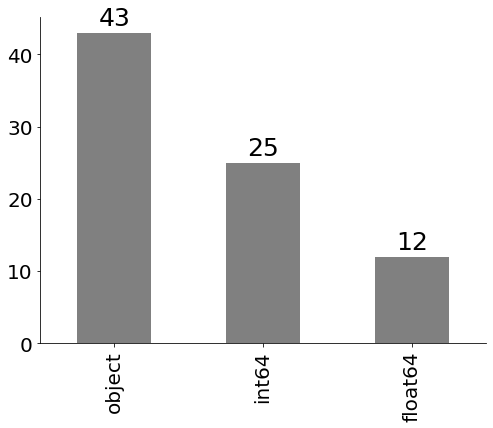

In [9]:
plt.figure(figsize = (8,6))
ax = house_df.dtypes.value_counts().plot(kind='bar',grid = False,fontsize=20,color='grey')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 1, height, ha = 'center', size = 25)
sns.despine()

In [10]:
categorical_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if
                    house_df[cname].nunique() < 10 and 
                    house_df[cname].dtype == "object"]

int_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if 
                house_df[cname].dtype in ['int64']]
float_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if 
                house_df[cname].dtype in ['float64']]

numerical_cols = int_cols + float_cols

my_cols = categorical_cols + numerical_cols

<AxesSubplot:>

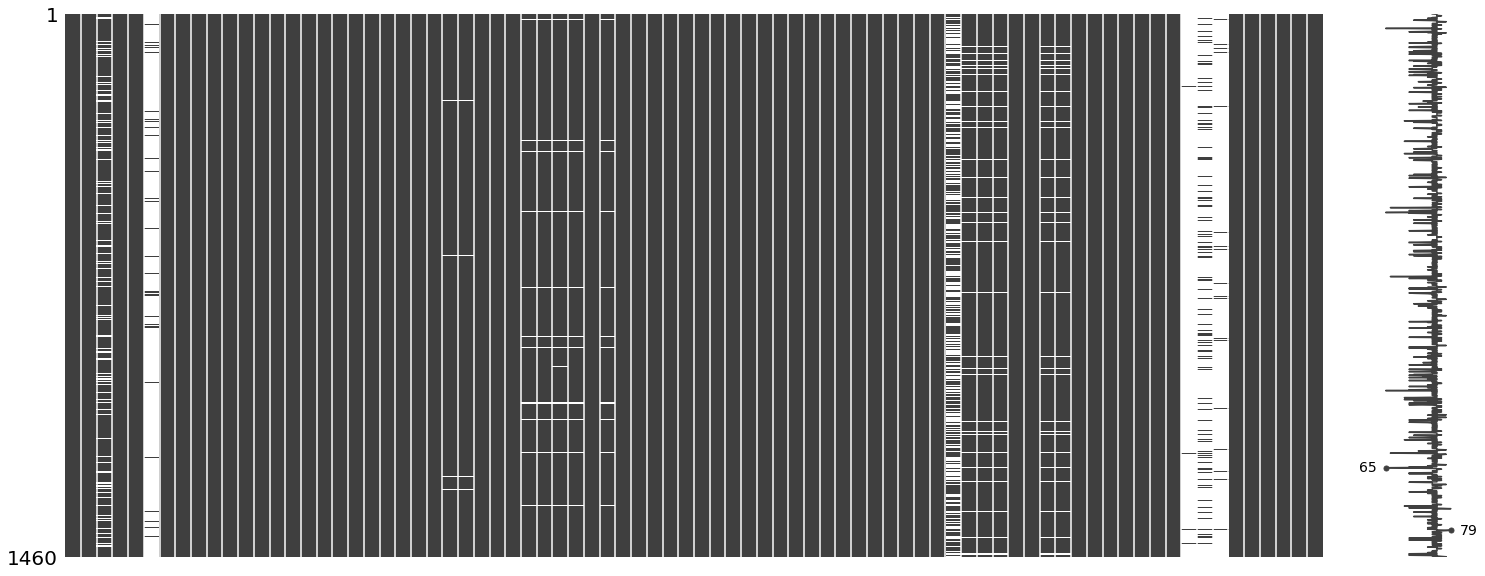

In [11]:
import missingno as msno
msno.matrix(house_df[tr_idx])

In [12]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
house_df.loc[:,numerical_cols] = imputer.fit_transform(house_df.loc[:,numerical_cols])

<AxesSubplot:>

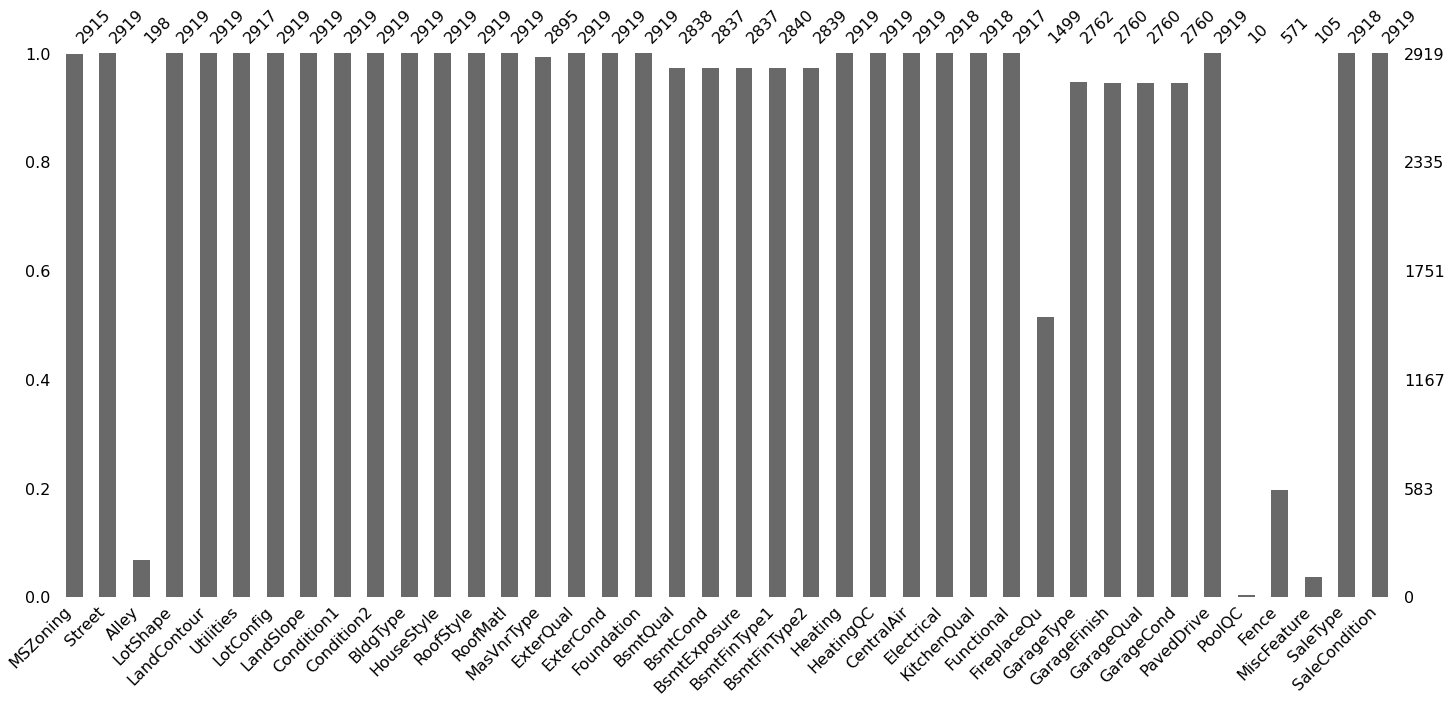

In [13]:
msno.bar(house_df.loc[:,categorical_cols])

In [14]:
house_df[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PoolQC       10 non-null     object
 1   MiscFeature  105 non-null    object
 2   Alley        198 non-null    object
 3   Fence        571 non-null    object
 4   FireplaceQu  1499 non-null   object
dtypes: object(5)
memory usage: 114.1+ KB


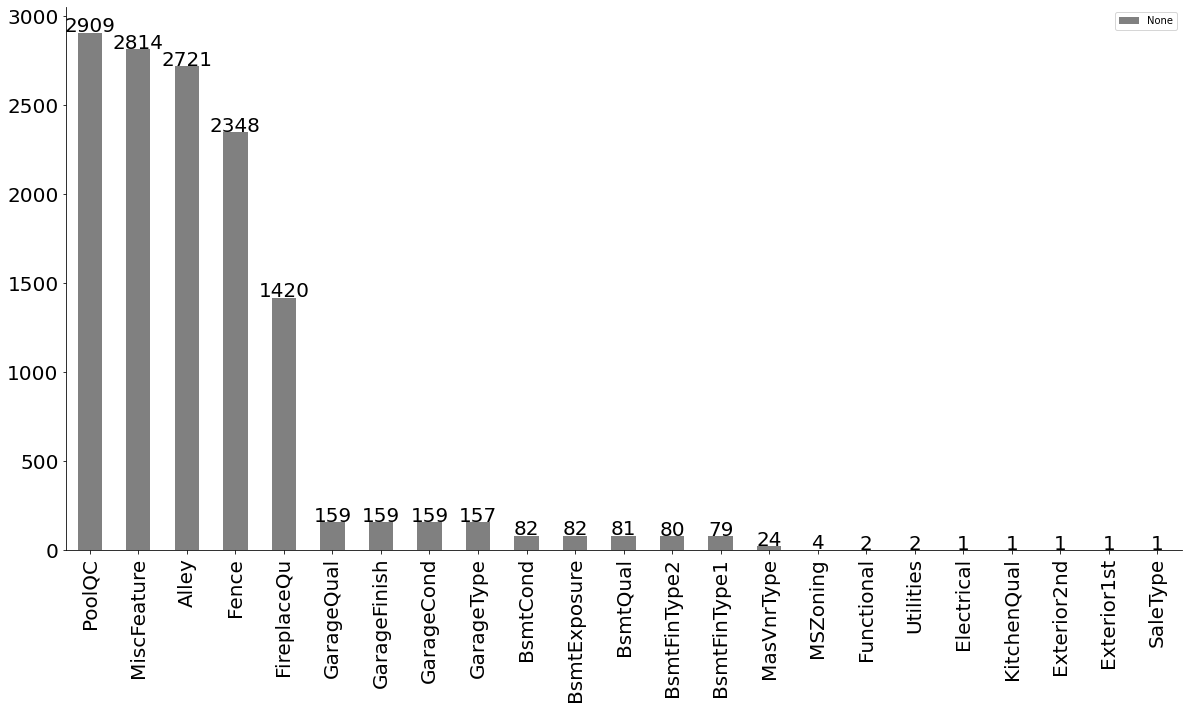

In [15]:
isnull_series = house_df.loc[:,:'SaleCondition'].isnull().sum()
isnull_series[isnull_series > 0].sort_values(ascending=False)

plt.figure(figsize = (20,10))
ax = isnull_series[isnull_series > 0].sort_values(ascending=False).plot(kind='bar',
                                                                        grid = False,
                                                                        fontsize=20,
                                                                        color='grey')
plt.legend(loc = 'upper right')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 5, height, ha = 'center', size = 20)
sns.despine()

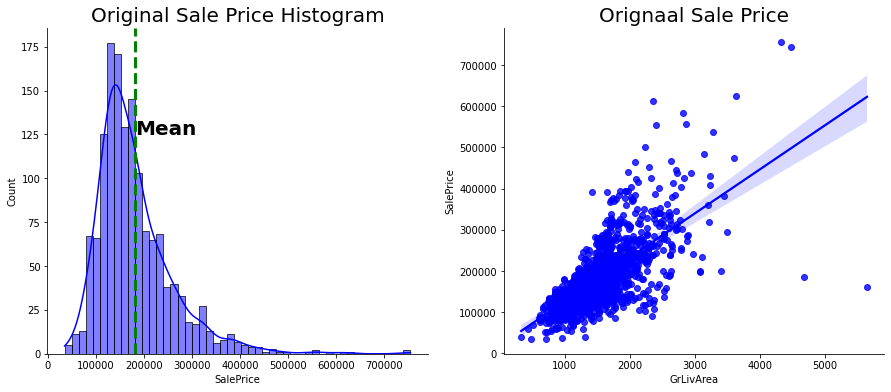

In [16]:
house_df['SalePriceCpy'] = house_df['SalePrice'].copy()
plt.figure(figsize = (15,6))
ax1 = plt.subplot(1,2,1)
sns.histplot(house_df['SalePrice'],color='Blue',kde=True)
plt.axvline(x=house_df['SalePrice'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(house_df['SalePrice'].mean(), 125, "Mean", horizontalalignment='left', size=20, color='black', weight='semibold')
plt.title('Original Sale Price Histogram',fontsize=20)
ax2 = plt.subplot(1,2,2)
sns.regplot(data=house_df, y="SalePrice", x="GrLivArea",ax=ax2,color='Blue')
ax2.set_title('Orignaal Sale Price',fontsize=20)
sns.despine()

In [17]:
mean = house_df['SalePrice'].mean()
std = house_df['SalePrice'].std()
skew = house_df['SalePrice'].skew()
print('SalePrice : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

SalePrice : mean: 180921.1959, std: 79442.5029, skew: 1.8829


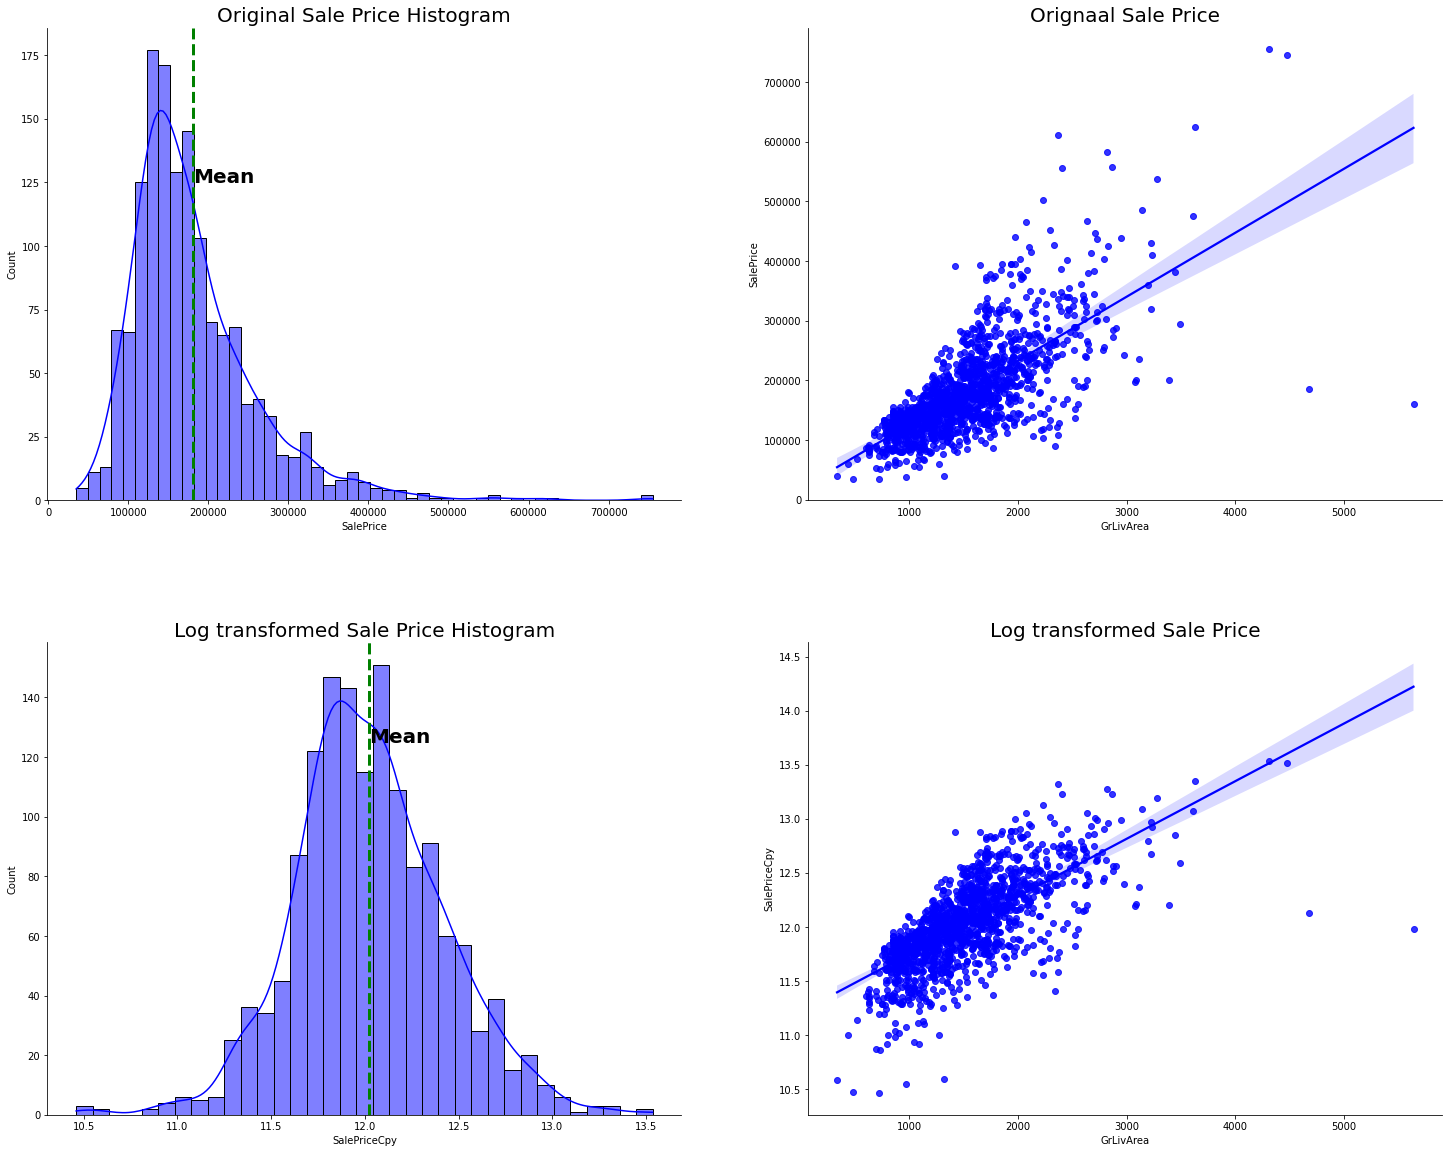

In [18]:
house_df['SalePriceCpy'] = np.log1p(house_df['SalePrice'])
plt.figure(figsize = (25,20))
plt.subplots_adjust(hspace=0.3)
ax1 = plt.subplot(2,2,1)
sns.histplot(house_df['SalePrice'],color='Blue',kde=True)
plt.axvline(x=house_df['SalePrice'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(house_df['SalePrice'].mean(), 125, "Mean", horizontalalignment='left', size=20, color='black', weight='semibold')
plt.title('Original Sale Price Histogram',fontsize=20)
ax2 = plt.subplot(2,2,2)
sns.regplot(data=house_df, y="SalePrice", x="GrLivArea",ax=ax2,color='Blue')
ax2.set_title('Orignaal Sale Price',fontsize=20)
ax3 = plt.subplot(2,2,3)
sns.histplot(house_df['SalePriceCpy'],color='Blue',kde=True)
plt.axvline(x=house_df['SalePriceCpy'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(house_df['SalePriceCpy'].mean(), 125, "Mean", horizontalalignment='left', size=20, color='black', weight='semibold')
plt.title('Log transformed Sale Price Histogram',fontsize=20)
ax4 = plt.subplot(2,2,4)
sns.regplot(data=house_df, y="SalePriceCpy", x="GrLivArea",ax=ax4,color='Blue')
ax4.set_title('Log transformed Sale Price',fontsize=20)
sns.despine()

In [19]:
mean = house_df['SalePriceCpy'].mean()
std = house_df['SalePriceCpy'].std()
skew = house_df['SalePriceCpy'].skew()
print('SalePrice : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

SalePrice : mean: 12.0241, std: 0.3994, skew: 0.1213


In [20]:
house_df.drop('SalePriceCpy',axis=1,inplace=True,errors='ignore')

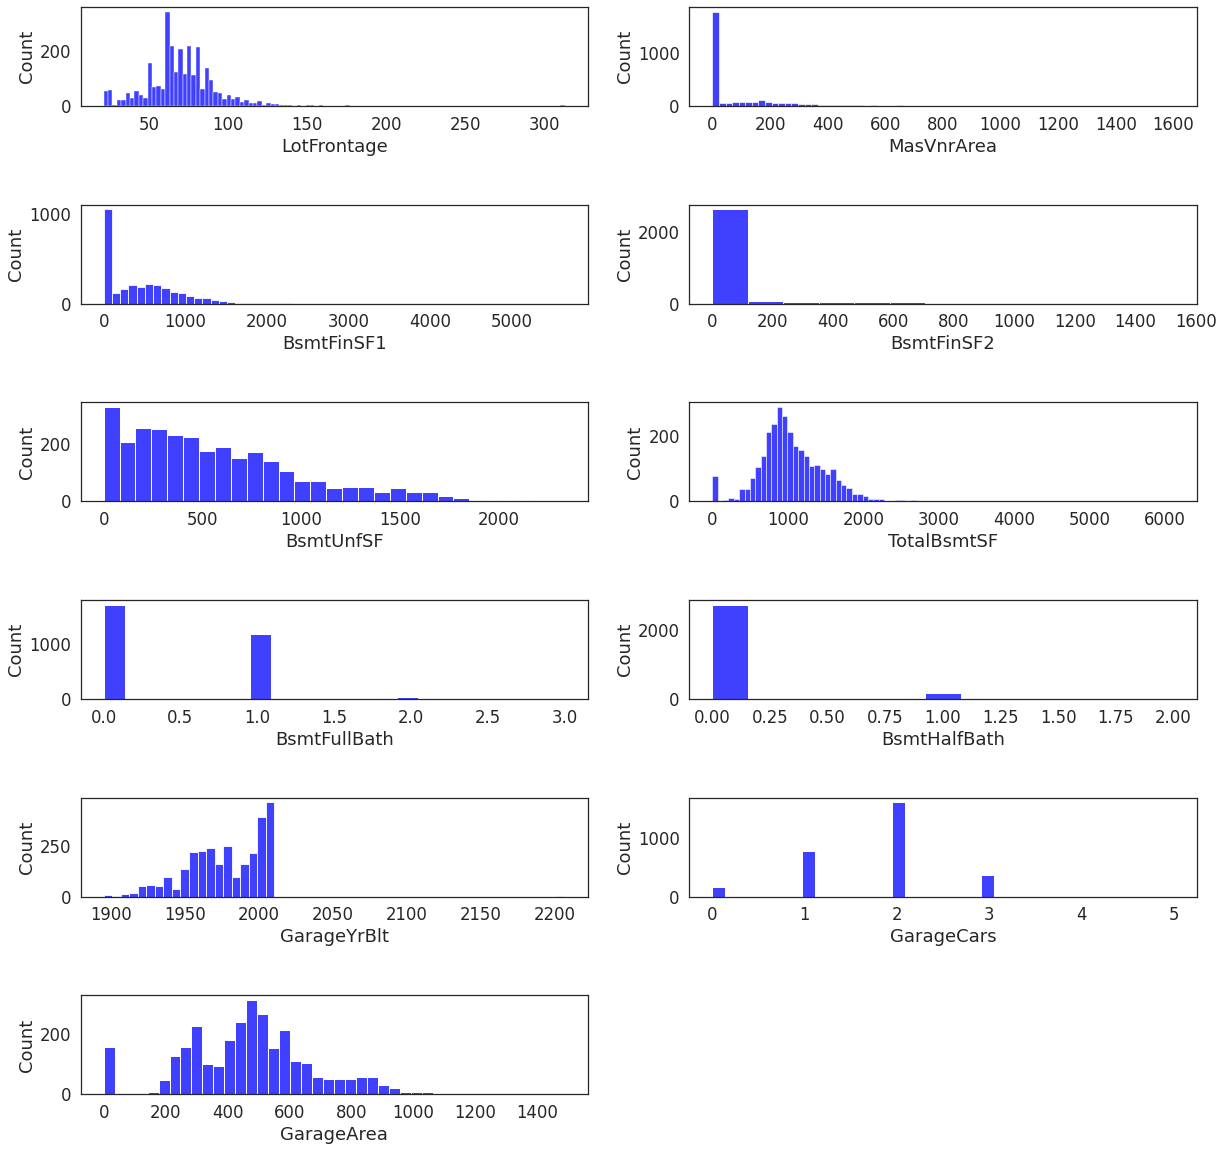

In [21]:
i = 1
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=1)
for feature in float_cols:
    plt.subplot(6,2,i)
    sns.histplot(house_df[feature], color='Blue')
    i = i +1

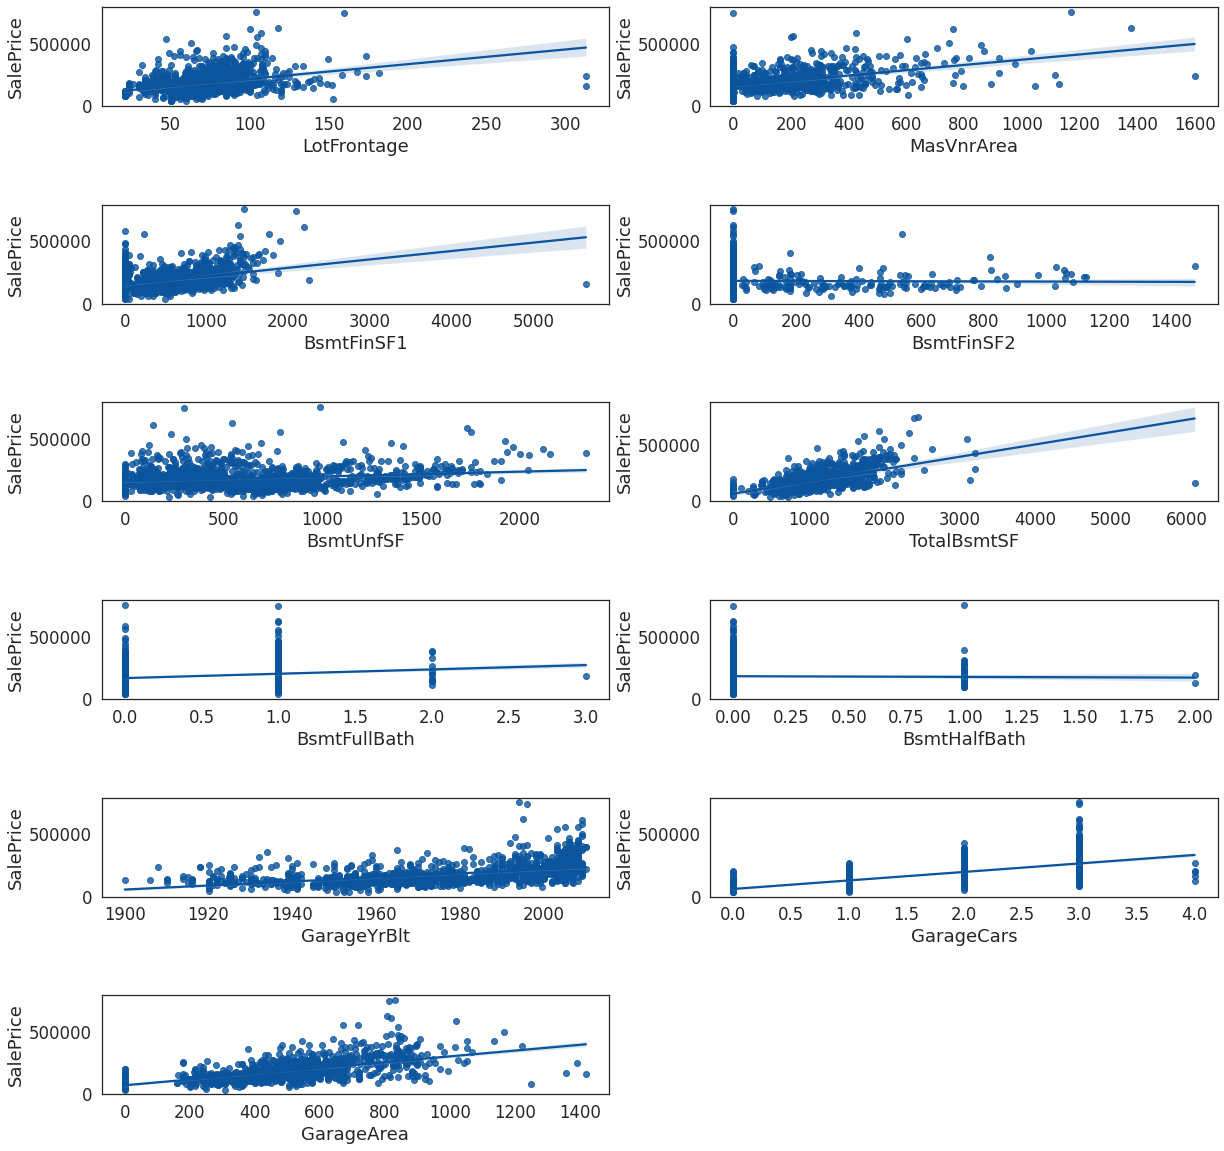

In [22]:
i = 1
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=1)
for feature in float_cols:
    plt.subplot(6,2,i)
    sns.regplot(data=house_df, x=feature,y='SalePrice')
    i = i +1

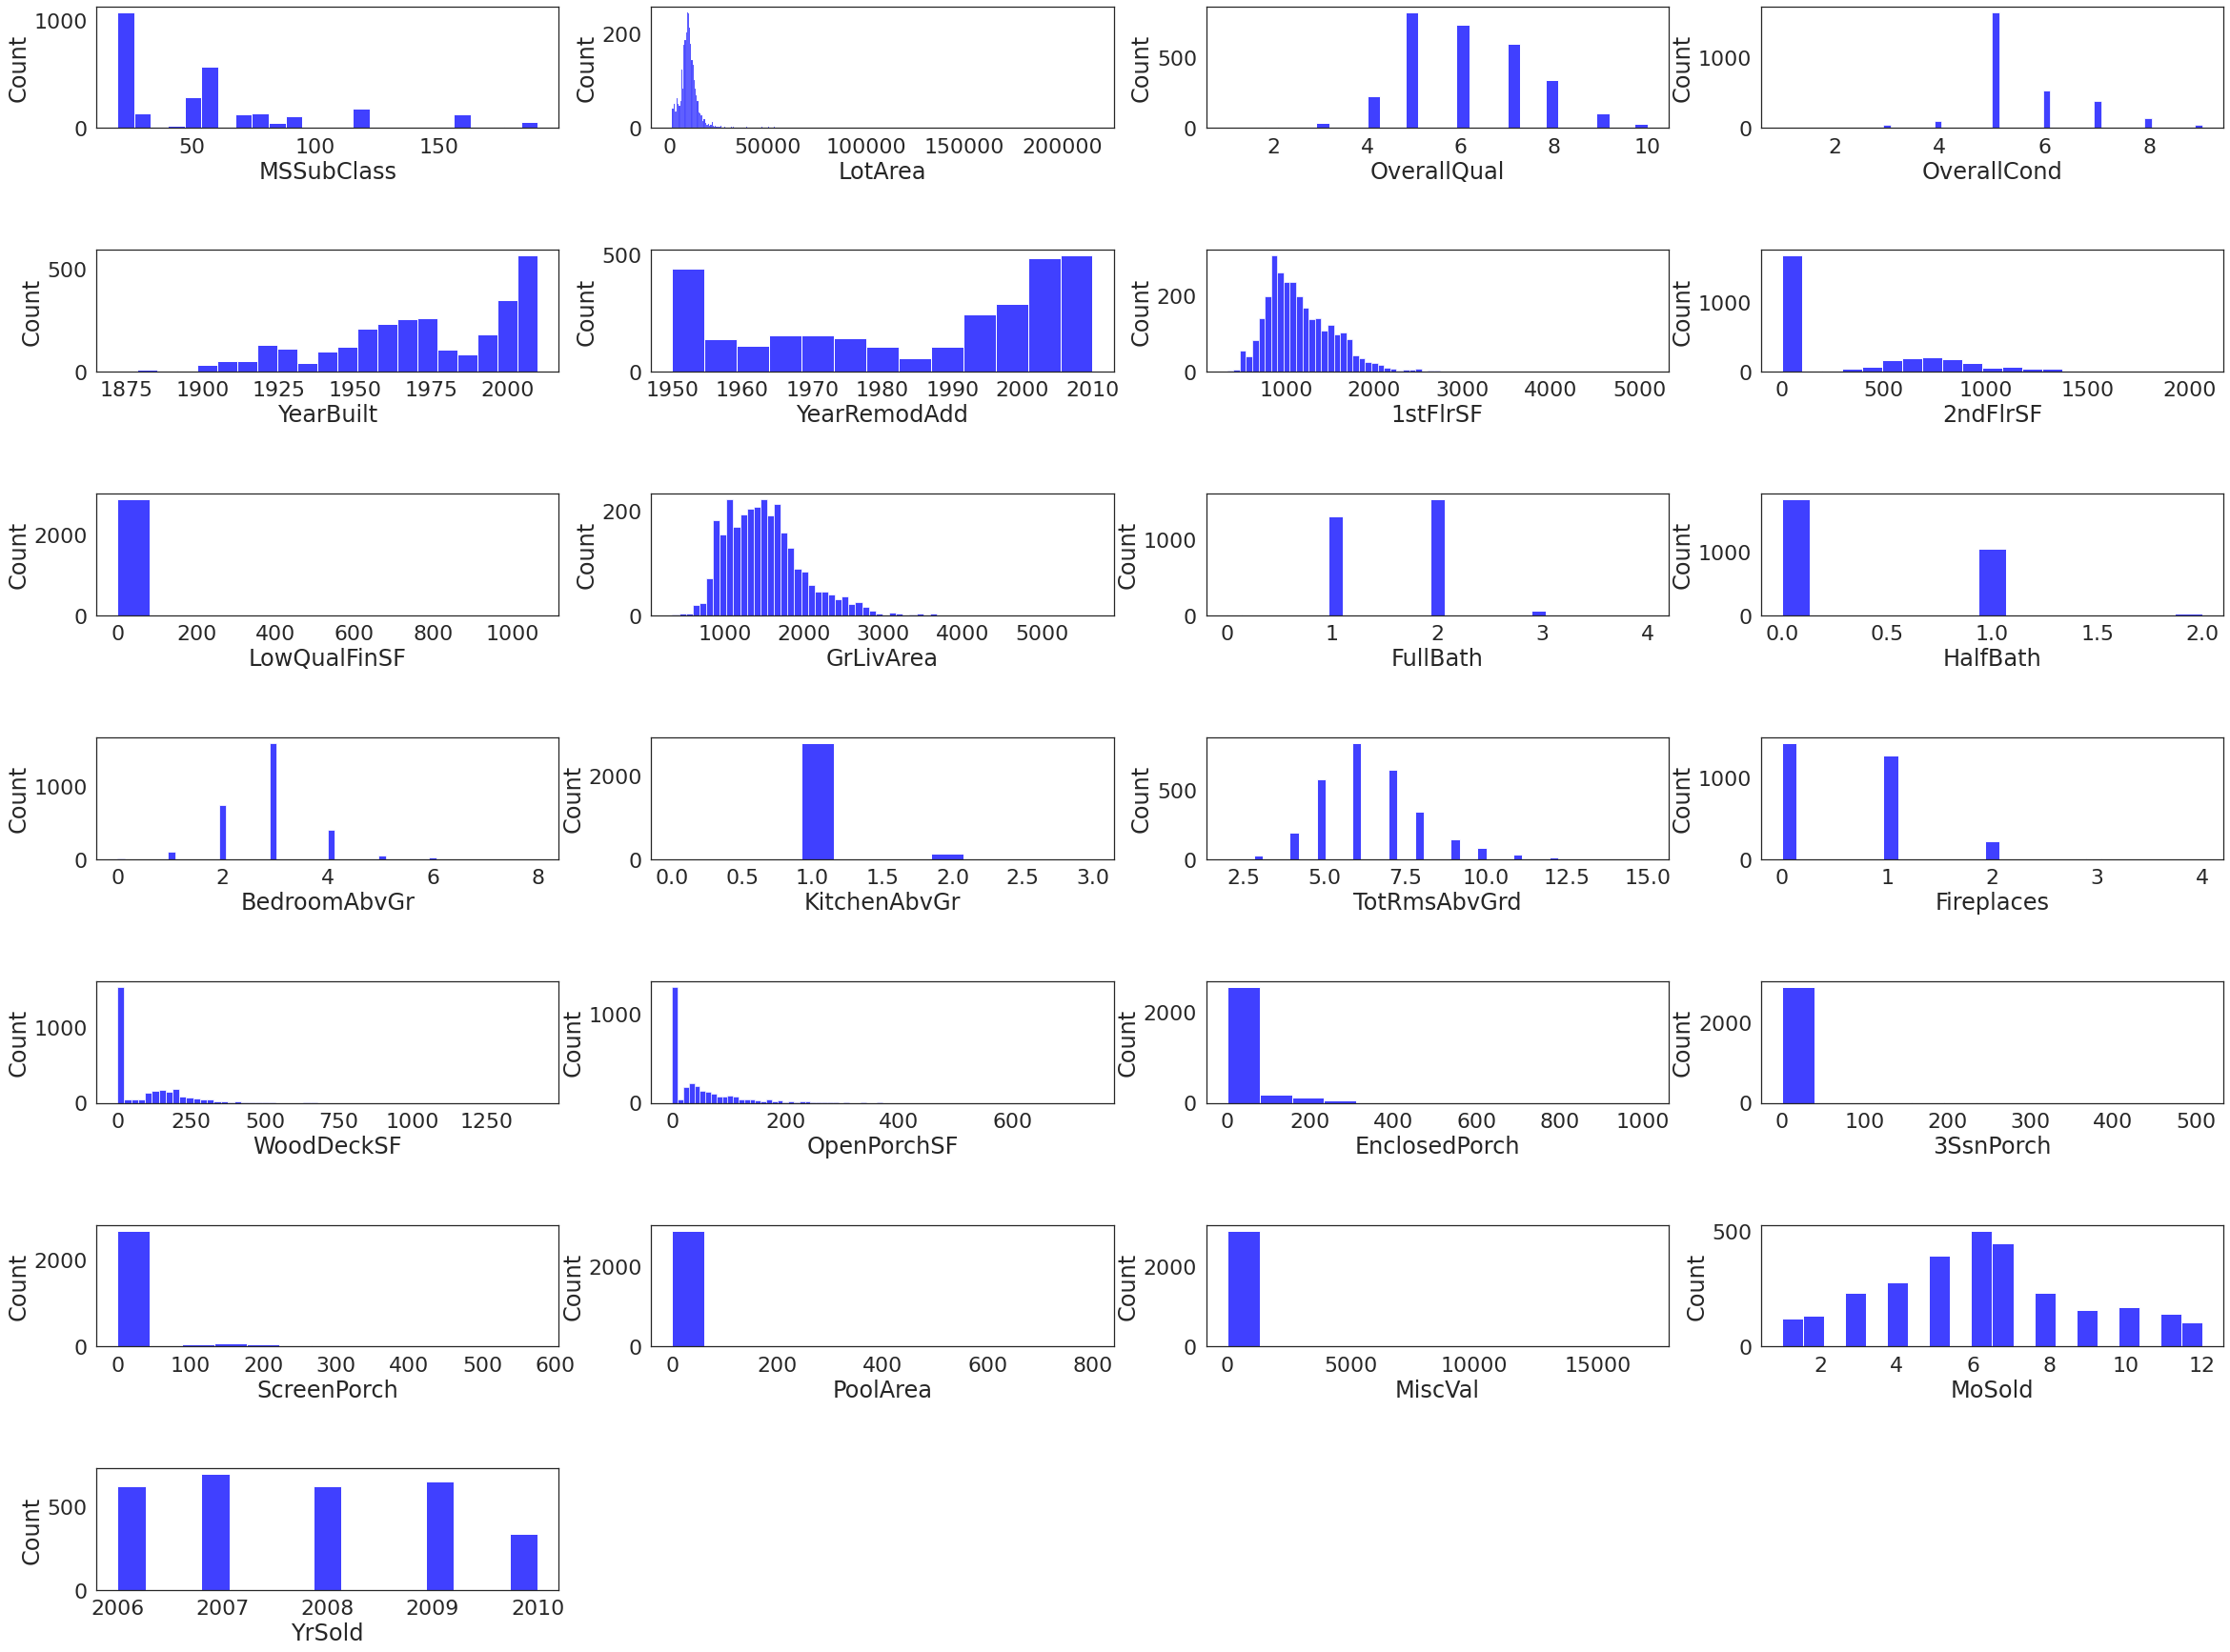

In [23]:
i = 1
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(40, 40))
plt.subplots_adjust(hspace=1)
for feature in int_cols:
    plt.subplot(9,4,i)
    sns.histplot(house_df[feature], color='Blue')
    i = i +1

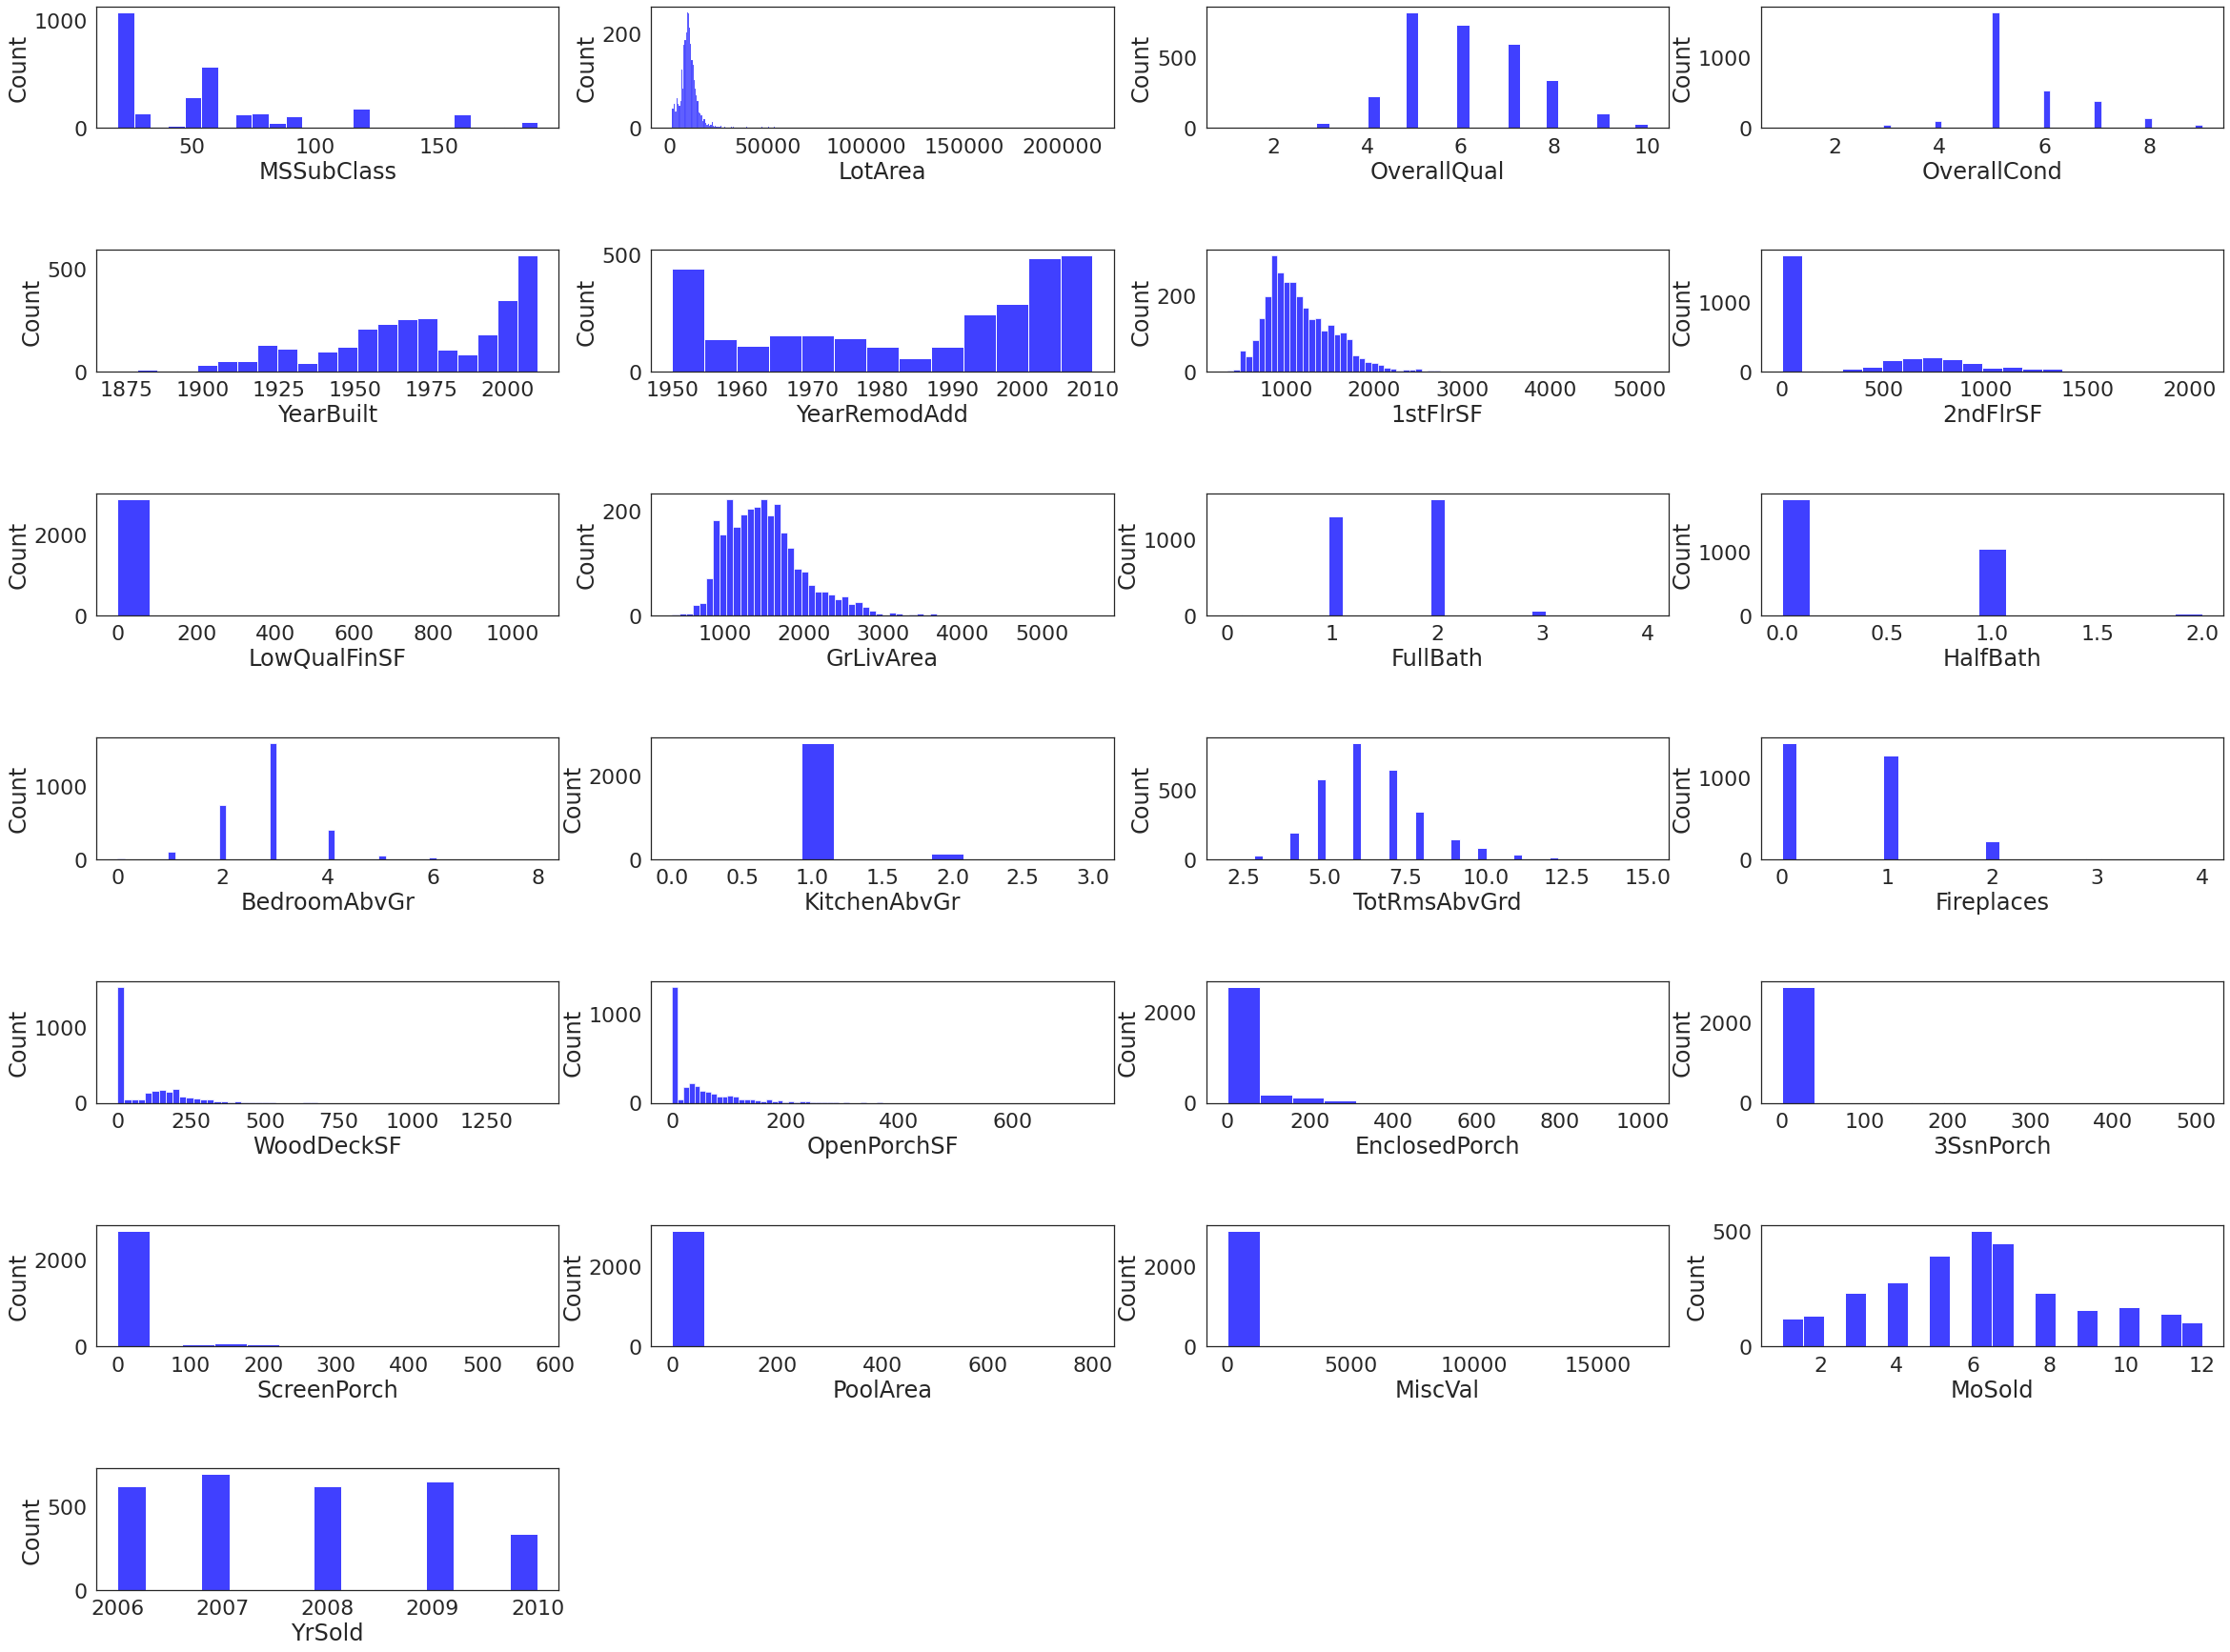

In [24]:
i = 1
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(40, 40))
plt.subplots_adjust(hspace=1)
for feature in int_cols:
    plt.subplot(9,4,i)
    sns.histplot(house_df[feature], color='Blue')
    i = i +1

In [25]:
categorical_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if
                    house_df[cname].nunique() < 10 and 
                    house_df[cname].dtype == "object"]

int_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if 
                house_df[cname].dtype in ['int64']]
float_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if 
                house_df[cname].dtype in ['float64']]

numerical_cols = int_cols + float_cols

my_cols = categorical_cols + numerical_cols

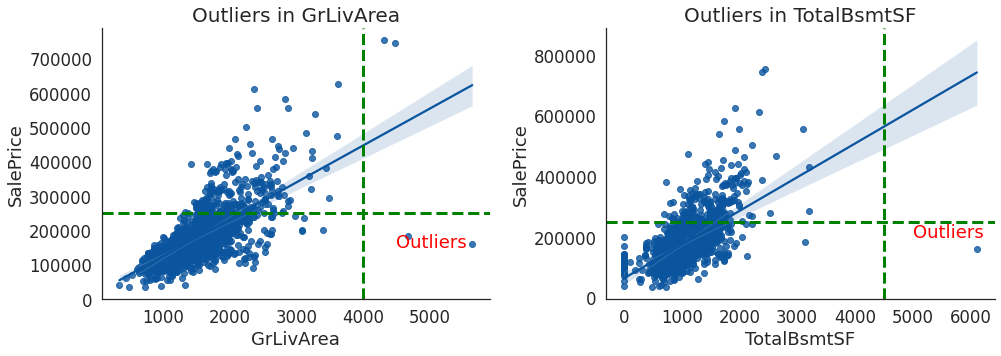

In [26]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.3)
ax1 = sns.regplot(data=house_df, x='GrLivArea',y='SalePrice')
ax1.set_title('Outliers in GrLivArea',fontsize=20)
plt.axhline(y=250000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4000, color='Green', linestyle='--', linewidth=3)
plt.text(4500, 150000, 'Outliers',color='red')
plt.subplot(1,2,2)
ax2 = sns.regplot(data=house_df, x='TotalBsmtSF',y='SalePrice')
ax2.set_title('Outliers in TotalBsmtSF',fontsize=20)
plt.axhline(y=250000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4500, color='Green', linestyle='--', linewidth=3)
plt.text(5000, 200000, 'Outliers',color='red')
sns.despine()

In [27]:
features = ["GarageArea","OverallQual","TotalBsmtSF","GrLivArea"]
house_copy = house_df[tr_idx].copy()
y_copy = house_copy.pop("SalePrice")
X_copy = house_copy.loc[:, features]

X_copy.isnull().sum()
pca, X_pca, loadings = apply_pca(X_copy)
print(loadings)

                  PC1       PC2       PC3       PC4
GarageArea   0.491792  0.290203 -0.776894  0.265253
OverallQual  0.532281 -0.179238 -0.012464 -0.827282
TotalBsmtSF  0.482071  0.621855  0.594295  0.166485
GrLivArea    0.492367 -0.704948  0.207593  0.466399


In [28]:
import plotly.express as px
fig = px.histogram(X_pca.melt(), color="variable", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "PCA Histogram",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)

In [29]:
pc1_outlier_idx = list(outlier_iqr(X_pca['PC1'])[0])
component = "PC1"

pc1_idx = X_pca[component].sort_values(ascending=False).index
df_temp_pc1 = house_df.loc[pc1_idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

df_temp_pc1.iloc[pc1_outlier_idx,:].style.set_properties(**{'background-color': 'Grey',
                            'color': 'white',
                            'border-color': 'darkblack'})

,SalePrice,Neighborhood,SaleCondition,GarageArea,OverallQual,TotalBsmtSF,GrLivArea
1346,262500.000000,NWAmes,Normal,508.000000,7.000000,1568.000000,2156.000000
559,234000.000000,Blmngtn,Normal,420.000000,7.000000,1374.000000,1557.000000
1154,201800.000000,NAmes,Normal,492.000000,7.000000,864.000000,1820.000000
1247,169900.000000,Mitchel,Normal,888.000000,6.000000,1012.000000,1034.000000
435,212000.000000,CollgCr,Normal,550.000000,7.000000,799.000000,1661.000000
298,175000.000000,NWAmes,Normal,539.000000,6.000000,702.000000,1743.000000
1398,138000.000000,NAmes,Normal,240.000000,5.000000,1208.000000,1904.000000
571,120000.000000,NAmes,Abnorml,288.000000,6.000000,864.000000,864.000000
873,133000.000000,NAmes,Normal,288.000000,5.000000,832.000000,1268.000000
418,126000.000000,Edwards,AdjLand,240.000000,5.000000,756.000000,1134.000000


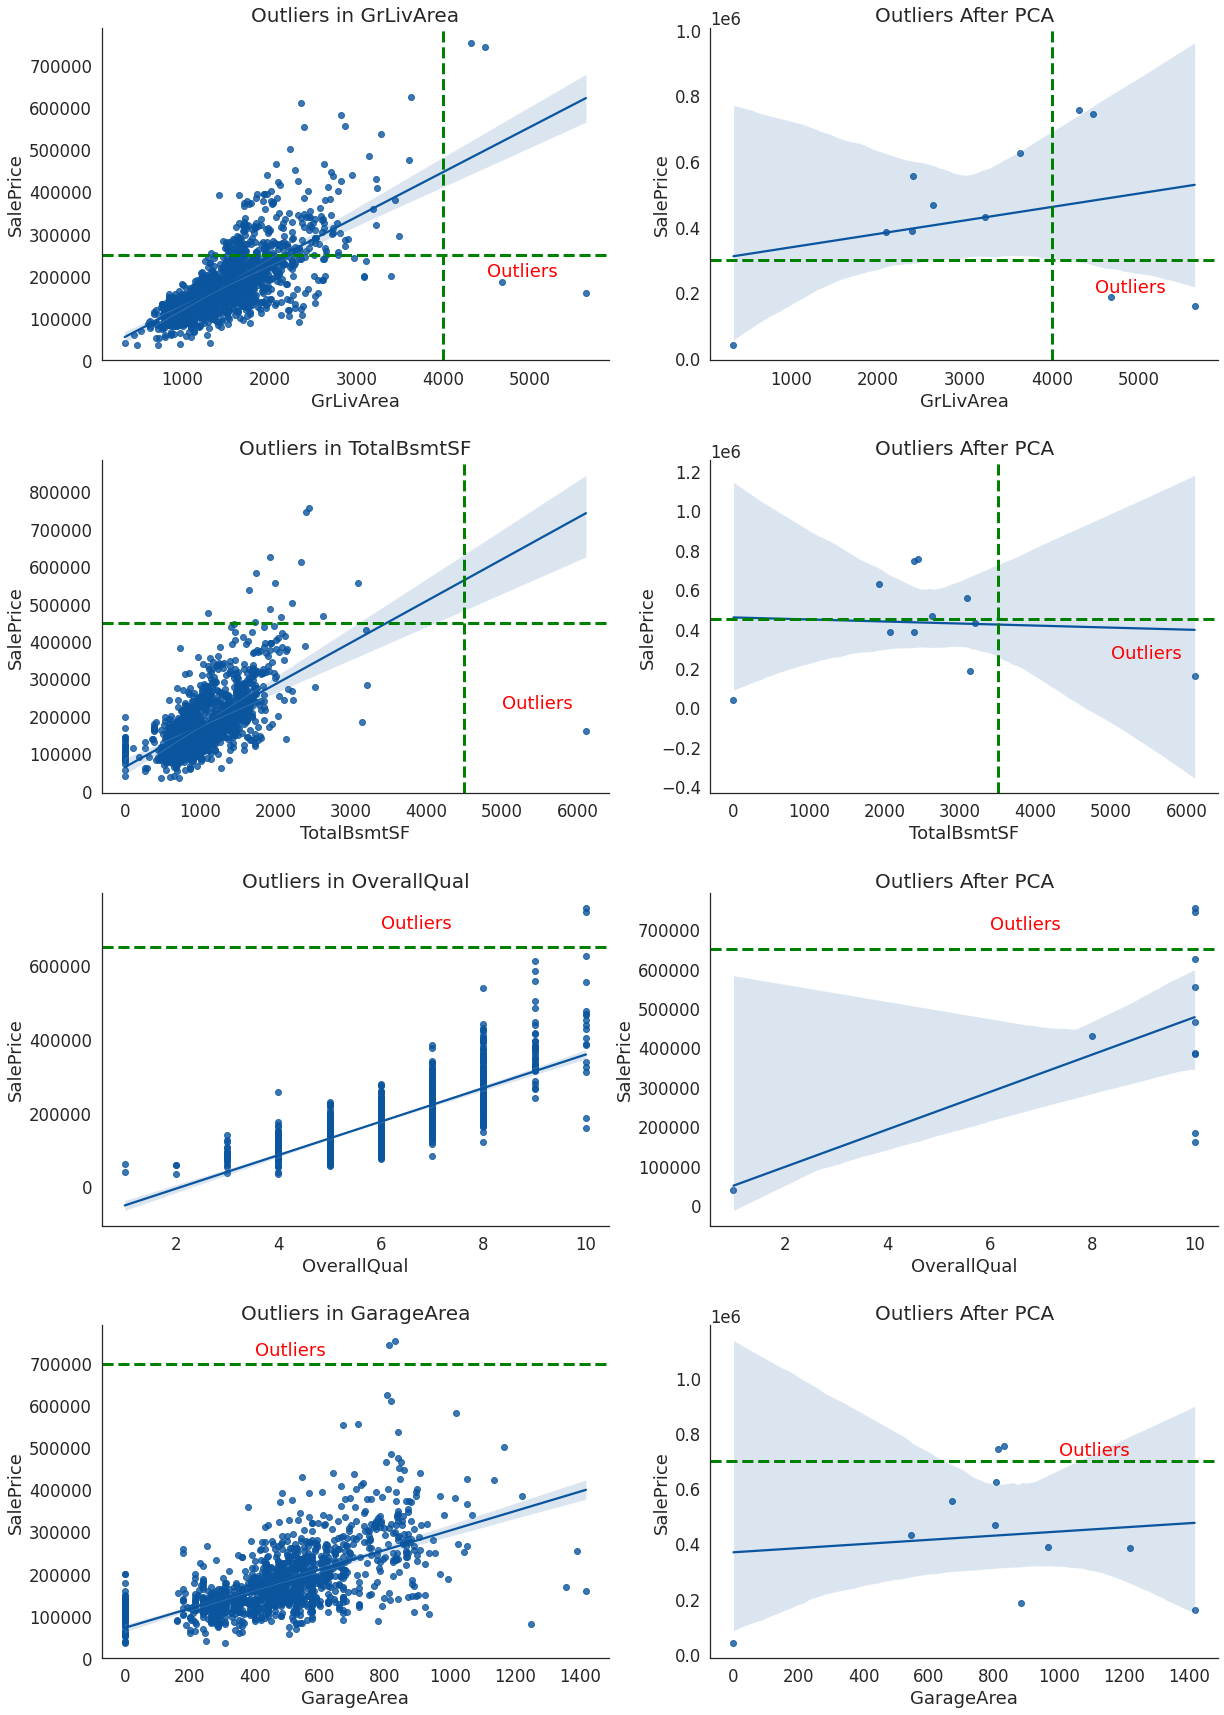

In [30]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.3)
plt.subplot(4,2,1)
ax1 = sns.regplot(data=house_df, x='GrLivArea',y='SalePrice')
ax1.set_title('Outliers in GrLivArea',fontsize=20)
plt.axhline(y=250000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4000, color='Green', linestyle='--', linewidth=3)
plt.text(4500, 200000, 'Outliers',color='red')
plt.subplot(4,2,2)
ax2 = sns.regplot(data=house_df.iloc[pc1_outlier_idx,:], x='GrLivArea',y='SalePrice')
ax2.set_title('Outliers After PCA',fontsize=20)
plt.axhline(y=300000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4000, color='Green', linestyle='--', linewidth=3)
plt.text(4500, 200000, 'Outliers',color='red')
plt.subplot(4,2,3)
ax3 = sns.regplot(data=house_df, x='TotalBsmtSF',y='SalePrice')
ax3.set_title('Outliers in TotalBsmtSF',fontsize=20)
plt.axhline(y=450000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4500, color='Green', linestyle='--', linewidth=3)
plt.text(5000, 220000, 'Outliers',color='red')
plt.subplot(4,2,4)
ax4 = sns.regplot(data=house_df.iloc[pc1_outlier_idx,:], x='TotalBsmtSF',y='SalePrice')
ax4.set_title('Outliers After PCA',fontsize=20)
plt.axhline(y=450000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=3500, color='Green', linestyle='--', linewidth=3)
plt.text(5000, 250000, 'Outliers',color='red')
plt.subplot(4,2,5)
ax5 = sns.regplot(data=house_df, x='OverallQual',y='SalePrice')
ax5.set_title('Outliers in OverallQual',fontsize=20)
plt.axhline(y=650000, color='Green', linestyle='--', linewidth=3)
plt.text(6, 700000, 'Outliers',color='red')
plt.subplot(4,2,6)
ax6 = sns.regplot(data=house_df.iloc[pc1_outlier_idx,:], x='OverallQual',y='SalePrice')
ax6.set_title('Outliers After PCA',fontsize=20)
plt.axhline(y=650000, color='Green', linestyle='--', linewidth=3)
plt.text(6, 700000, 'Outliers',color='red')
plt.subplot(4,2,7)
ax7 = sns.regplot(data=house_df, x='GarageArea',y='SalePrice')
ax7.set_title('Outliers in GarageArea',fontsize=20)
plt.axhline(y=700000, color='Green', linestyle='--', linewidth=3)
plt.text(400, 720000, 'Outliers',color='red')
plt.subplot(4,2,8)
ax8 = sns.regplot(data=house_df.iloc[pc1_outlier_idx,:], x='GarageArea',y='SalePrice')
ax8.set_title('Outliers After PCA',fontsize=20)
plt.axhline(y=700000, color='Green', linestyle='--', linewidth=3)
plt.text(1000, 720000, 'Outliers',color='red')
sns.despine()

In [31]:
pc2_outlier_idx = list(outlier_iqr(X_pca['PC2'])[0])
component = "PC2"

pc2_idx = X_pca[component].sort_values(ascending=False).index
df_temp_pc2 = house_df.loc[pc2_idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

df_temp_pc2.iloc[pc2_outlier_idx,:].style.set_properties(**{'background-color': 'Grey',
                            'color': 'white',
                            'border-color': 'darkblack'})

,SalePrice,Neighborhood,SaleCondition,GarageArea,OverallQual,TotalBsmtSF,GrLivArea
1406,133000.000000,CollgCr,Normal,396.000000,5.000000,768.000000,768.000000


In [32]:
house_df.drop(pc1_outlier_idx,axis=0,inplace=True,errors='ignore')
house_df.drop(pc2_outlier_idx,axis=0,inplace=True,errors='ignore')

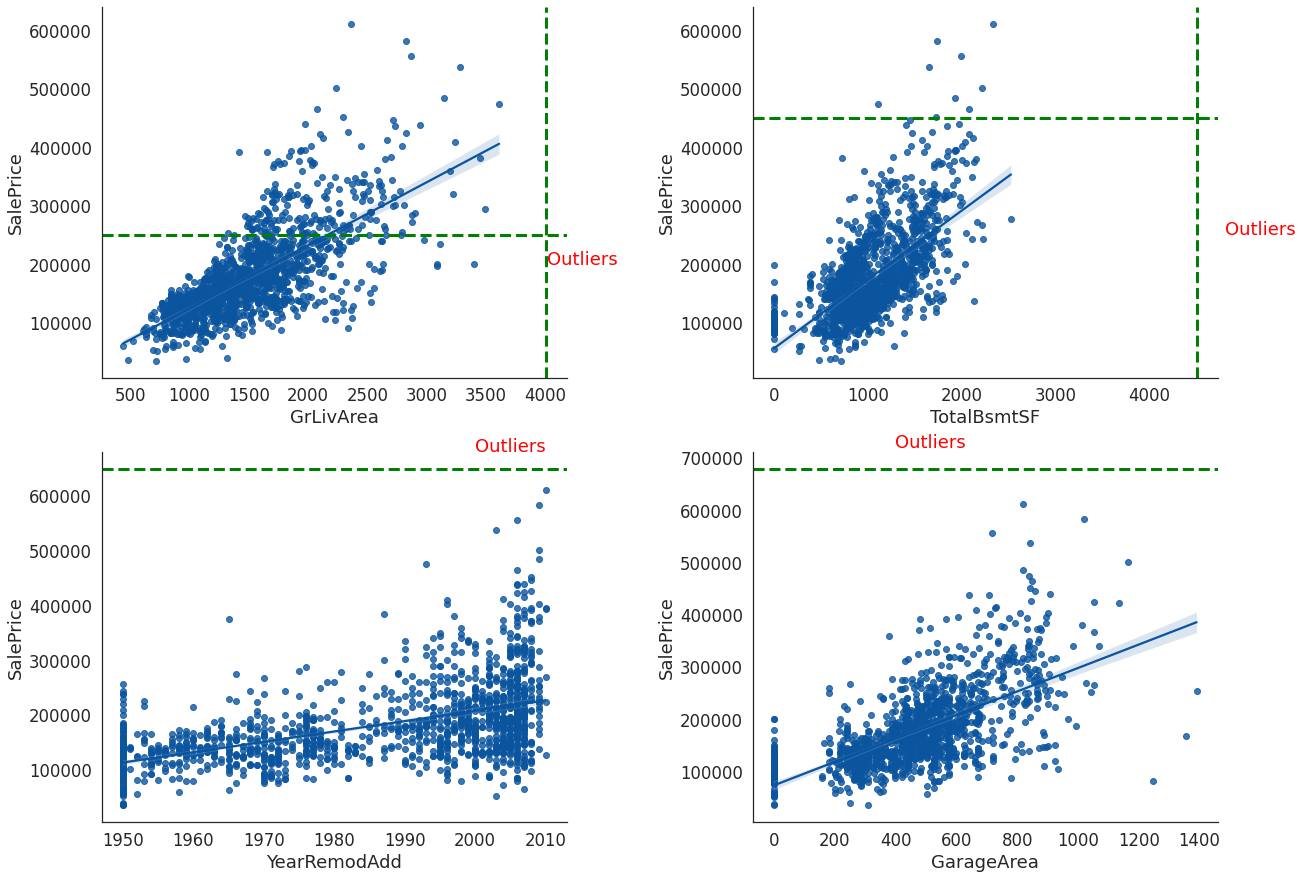

In [33]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=0.2,wspace=0.4)
plt.subplot(2,2,1)
sns.regplot(data=house_df, x='GrLivArea',y='SalePrice')
plt.axhline(y=250000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4000, color='Green', linestyle='--', linewidth=3)
plt.text(4010, 200000, 'Outliers',color='red')
plt.subplot(2,2,2)
sns.regplot(data=house_df, x='TotalBsmtSF',y='SalePrice')
plt.axhline(y=450000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4500, color='Green', linestyle='--', linewidth=3)
plt.text(4800, 250000, 'Outliers',color='red')
plt.subplot(2,2,3)
sns.regplot(data=house_df, x='YearRemodAdd',y='SalePrice')
plt.axhline(y=650000, color='Green', linestyle='--', linewidth=3)
plt.text(2000, 680000, 'Outliers',color='red')
plt.subplot(2,2,4)
sns.regplot(data=house_df, x='GarageArea',y='SalePrice')
plt.axhline(y=680000, color='Green', linestyle='--', linewidth=3)
plt.text(400, 720000, 'Outliers',color='red')
sns.despine()

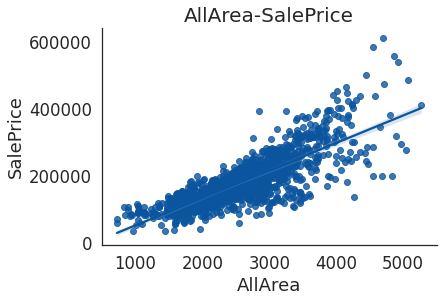

In [34]:
house_df["AllArea"] = house_df.GrLivArea + house_df.TotalBsmtSF
sns.set_style("white")
sns.set_palette("Blues_r")
sns.regplot(data=house_df, x='AllArea',y='SalePrice')
plt.title('AllArea-SalePrice',fontsize=20)
sns.despine()

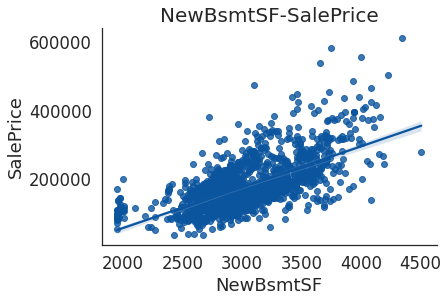

In [35]:
house_df["NewBsmtSF"] = house_df['YearRemodAdd'] + house_df['TotalBsmtSF']
sns.set_style("white")
sns.set_palette("Blues_r")
sns.regplot(data=house_df, x='NewBsmtSF',y='SalePrice')
plt.title('NewBsmtSF-SalePrice',fontsize=20)
sns.despine()

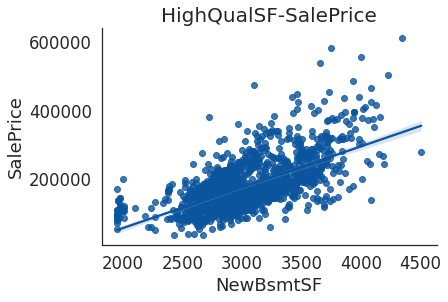

In [36]:
house_df["HighQualSF"] = house_df["1stFlrSF"] + house_df["2ndFlrSF"]
sns.set_style("white")
sns.set_palette("Blues_r")
sns.regplot(data=house_df, x='NewBsmtSF',y='SalePrice')
plt.title('HighQualSF-SalePrice',fontsize=20)
sns.despine()

In [37]:
categorical_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if
                    house_df[cname].nunique() < 10 and 
                    house_df[cname].dtype == "object"]

int_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if 
                house_df[cname].dtype in ['int64']]
float_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if 
                house_df[cname].dtype in ['float64']]

numerical_cols = int_cols + float_cols

my_cols = categorical_cols + numerical_cols

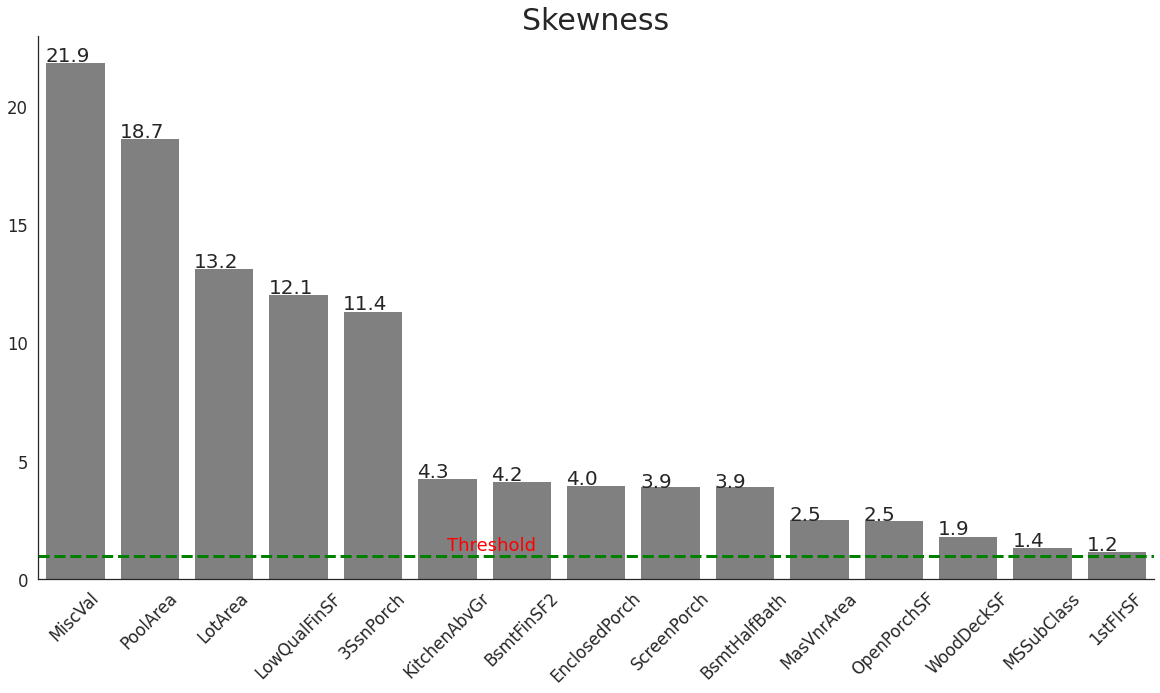

In [38]:
from scipy.stats import skew
plt.figure(figsize=(20, 10))
skew_features = house_df[numerical_cols].apply(lambda x : skew(x))
skew_features = skew_features[skew_features > 1].sort_values(ascending=False)
ax = sns.barplot( x =skew_features.index,y=skew_features.values,color='grey')
for p in ax.patches:
    height = p.get_height().round(1)
    ax.text(p.get_x()+ p.get_width()//2, height, height, ha = 'left', size = 20)
plt.xticks(rotation=45)
plt.text(5, 1.2, 'Threshold',color='red')
plt.axhline(y=1, color='green', linestyle='--', linewidth=3)
plt.title('Skewness',fontsize=30)
sns.despine()

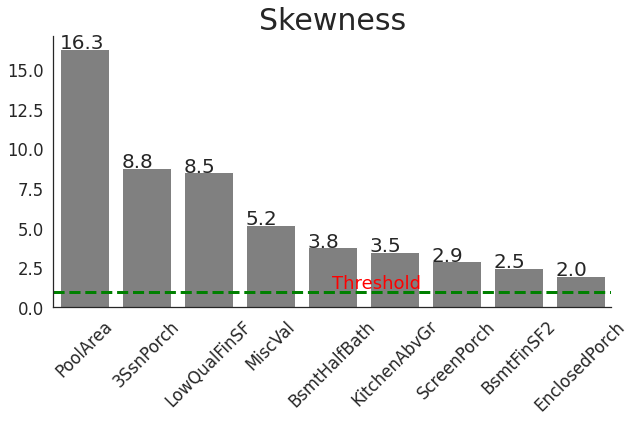

In [39]:
house_df[skew_features.index] = np.log1p(house_df[skew_features.index])
from scipy.stats import skew
plt.figure(figsize=(10, 5))
skew_features = house_df[numerical_cols].apply(lambda x : skew(x))
skew_features = skew_features[skew_features > 1].sort_values(ascending=False)
ax = sns.barplot( x =skew_features.index,y=skew_features.values,color='grey')
for p in ax.patches:
    height = p.get_height().round(1)
    ax.text(p.get_x()+ p.get_width()//2, height, height, ha = 'left', size = 20)
plt.xticks(rotation=45)
plt.axhline(y=1, color='green', linestyle='--', linewidth=3)
plt.text(4, 1.2, 'Threshold',color='red')
plt.title('Skewness',fontsize=30)
sns.despine()

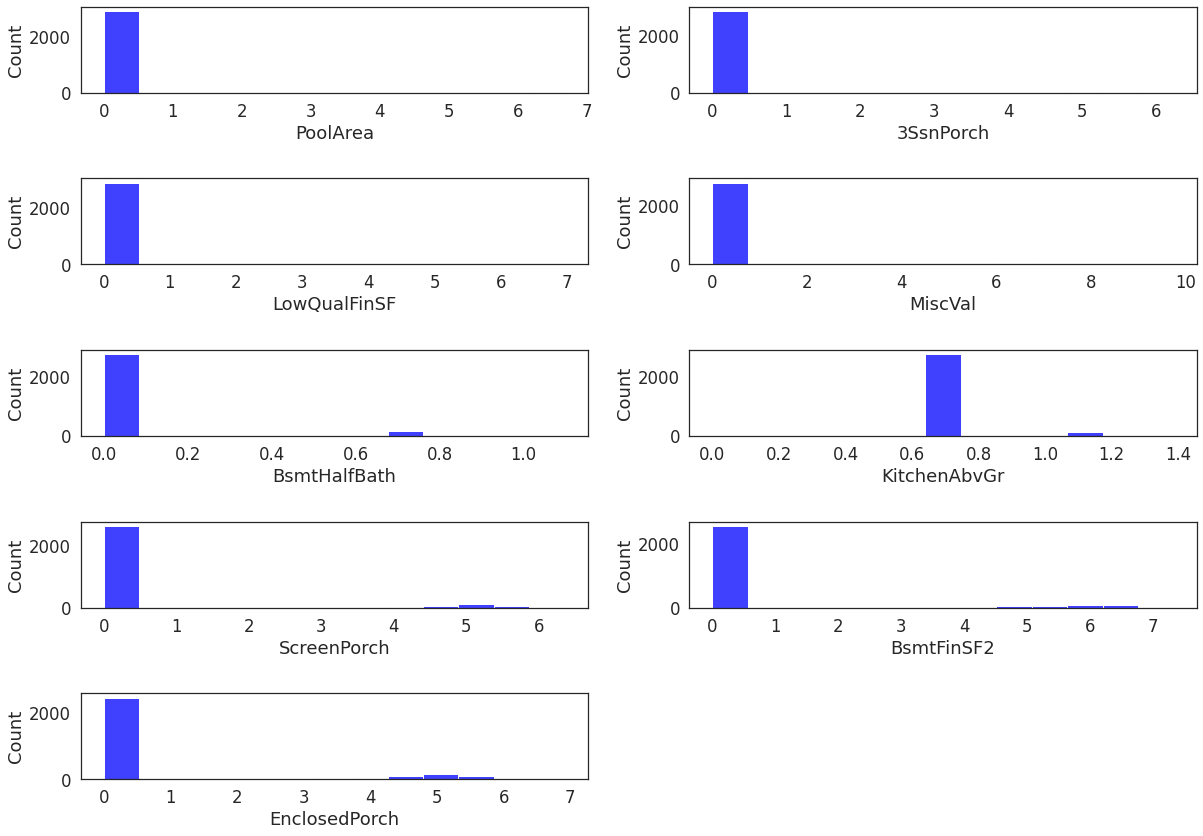

In [40]:
i = 1
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("gist_yarg_r")
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=1)
for feature in skew_features.index:
    plt.subplot(10,2,i)
    sns.histplot(house_df[feature], color='blue')
    i = i +1

In [41]:
categorical_cols = [cname for cname in house_df.columns if
                    house_df[cname].dtype == "object"]

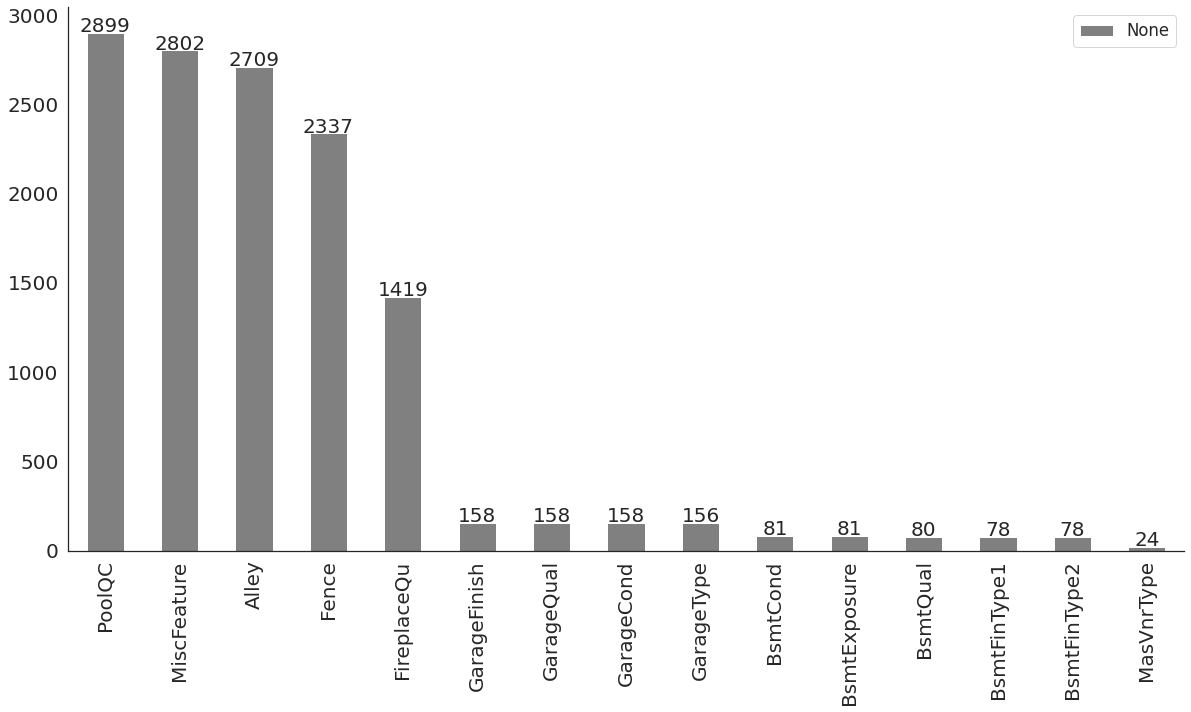

In [42]:
isnull_series = house_df.loc[:,:'SaleCondition'].isnull().sum()
isnull_series[isnull_series >= 20].sort_values(ascending=False)

plt.figure(figsize = (20,10))
ax = isnull_series[isnull_series >= 20].sort_values(ascending=False).plot(kind='bar',
                                                                        grid = False,
                                                                        fontsize=20,
                                                                        color='grey')
plt.legend(loc = 'upper right')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 5, height, ha = 'center', size = 20)
sns.despine()

<AxesSubplot:xlabel='HasPoolQC', ylabel='SalePrice'>

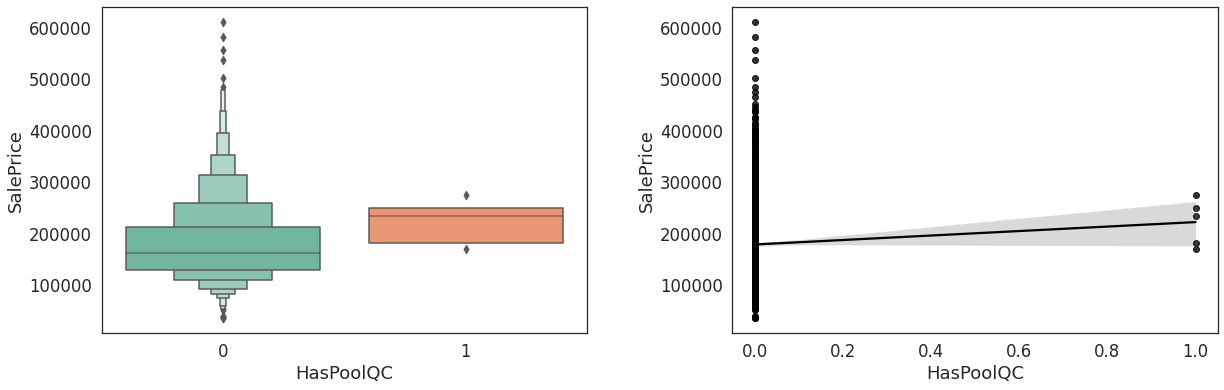

In [43]:
house_df['HasPoolQC'] = house_df['PoolQC'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasPoolQC',y='SalePrice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasPoolQC',y='SalePrice',color='black')

<AxesSubplot:xlabel='HasMiscFeature', ylabel='SalePrice'>

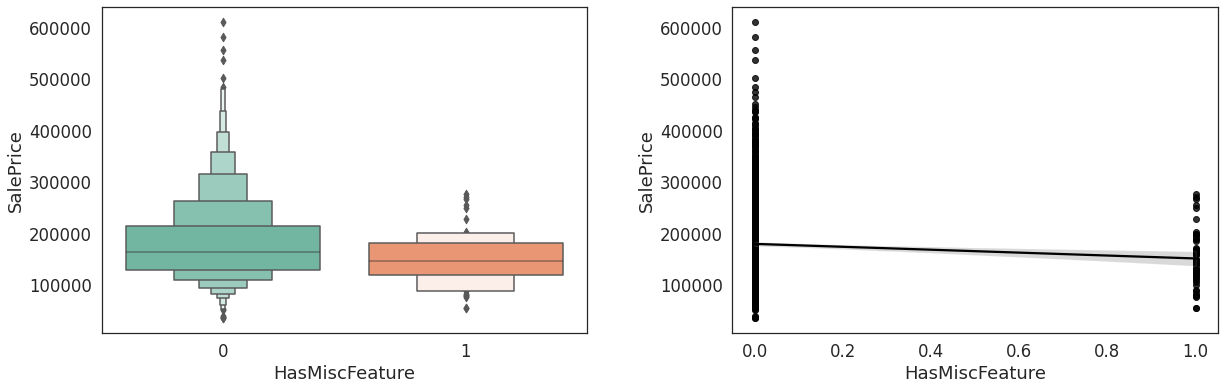

In [44]:
house_df['HasMiscFeature'] = house_df['MiscFeature'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasMiscFeature',y='SalePrice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasMiscFeature',y='SalePrice',color='black')

<AxesSubplot:xlabel='HasAlley', ylabel='SalePrice'>

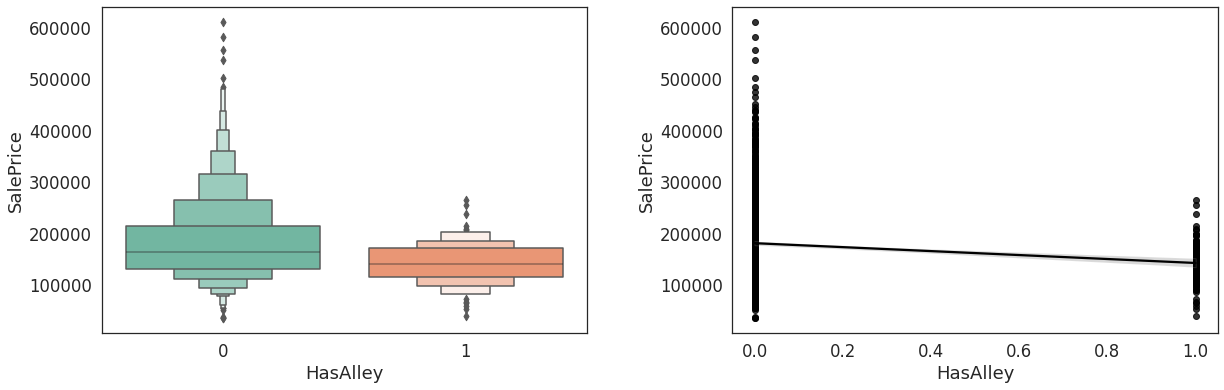

In [45]:
house_df['HasAlley'] = house_df['Alley'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasAlley',y='SalePrice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasAlley',y='SalePrice',color='black')

<AxesSubplot:xlabel='HasFence', ylabel='SalePrice'>

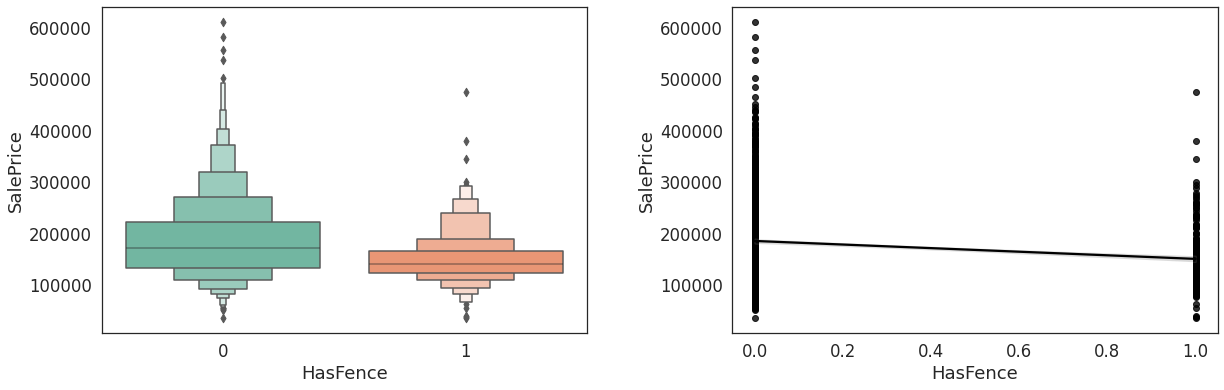

In [46]:
house_df['HasFence'] = house_df['Fence'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasFence',y='SalePrice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasFence',y='SalePrice',color='black')

<AxesSubplot:xlabel='HasFireplaceQu', ylabel='SalePrice'>

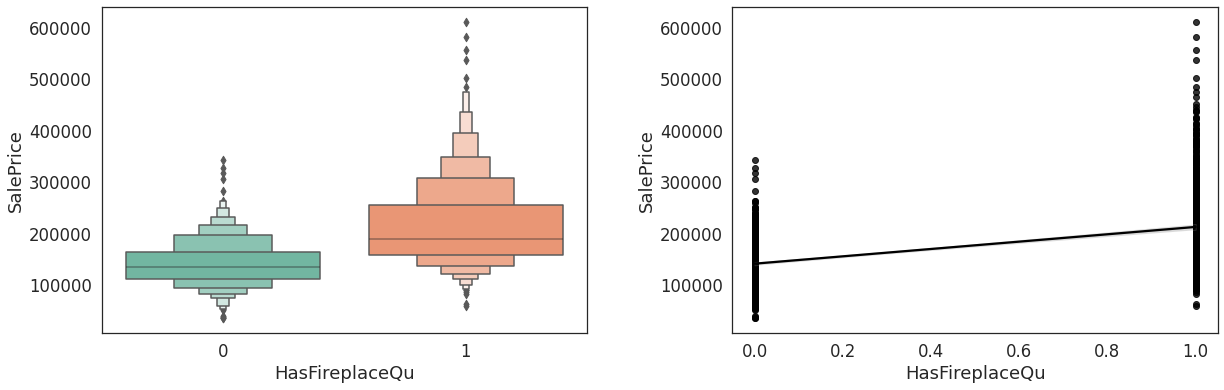

In [47]:
house_df['HasFireplaceQu'] = house_df['FireplaceQu'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasFireplaceQu',y='SalePrice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasFireplaceQu',y='SalePrice',color='black')

<AxesSubplot:xlabel='HasGarageQual', ylabel='SalePrice'>

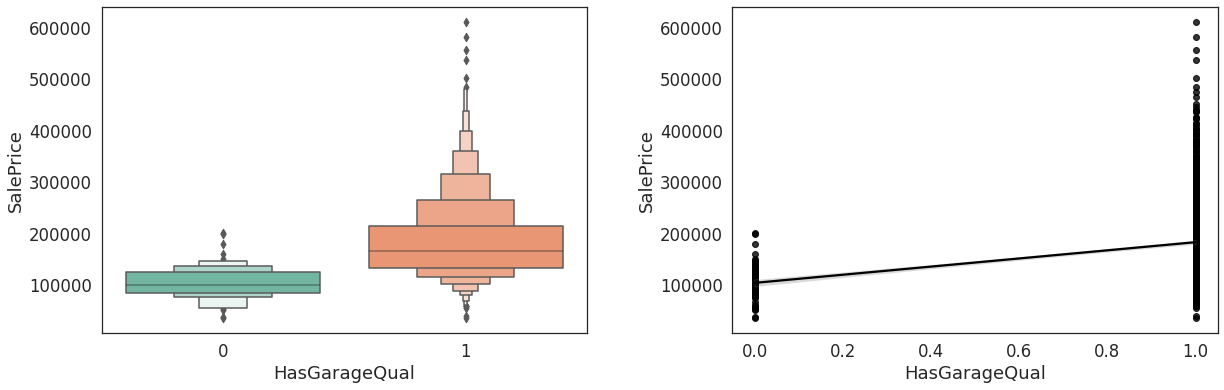

In [48]:
house_df['HasGarageQual'] = house_df['GarageQual'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasGarageQual',y='SalePrice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasGarageQual',y='SalePrice',color='black')

<AxesSubplot:xlabel='HasBsmtQual', ylabel='SalePrice'>

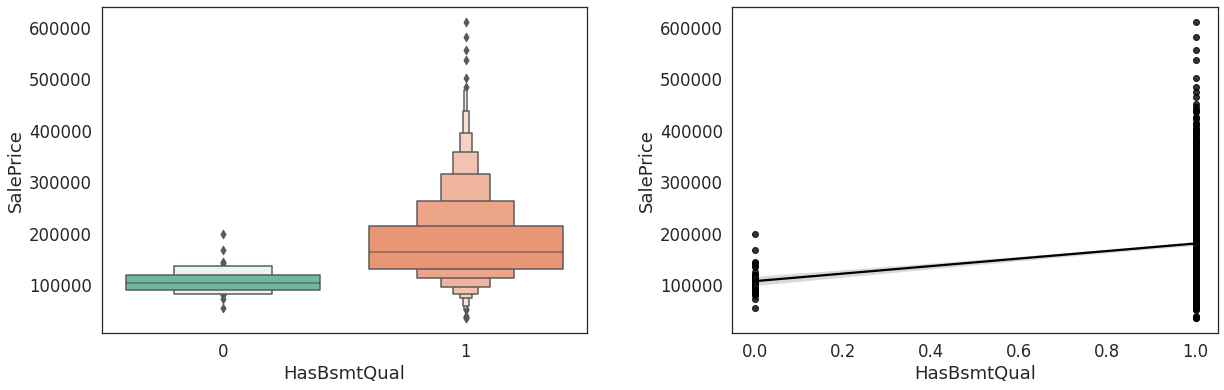

In [49]:
house_df['HasBsmtQual'] = house_df['BsmtQual'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasBsmtQual',y='SalePrice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasBsmtQual',y='SalePrice',color='black')

<AxesSubplot:xlabel='HasMasVnrType', ylabel='SalePrice'>

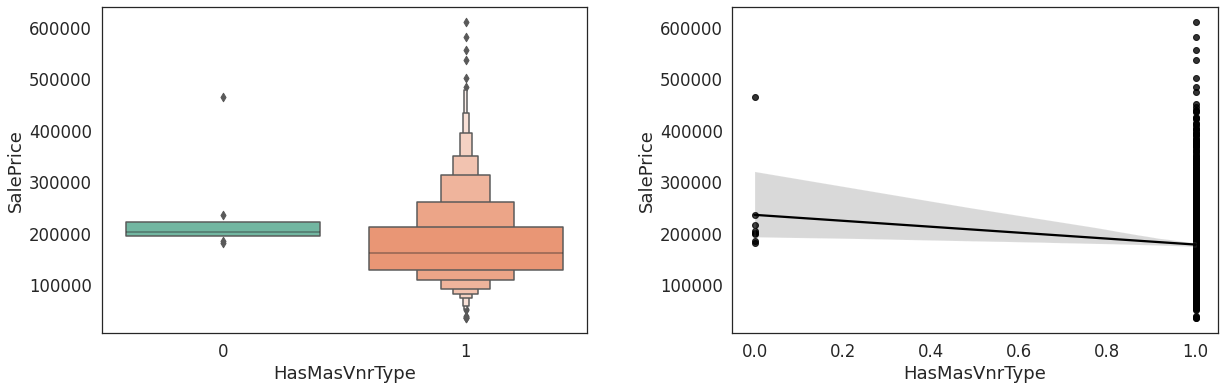

In [50]:
house_df['HasMasVnrType'] = house_df['MasVnrType'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasMasVnrType',y='SalePrice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasMasVnrType',y='SalePrice',color='black')

In [51]:
house_df['Alley'] = house_df['Alley'].fillna('missing')
house_df['MasVnrType'] = house_df['MasVnrType'].fillna('None')
house_df['GarageType'] = house_df['GarageType'].fillna('missing')
house_df['GarageCond'] = house_df['GarageCond'].fillna('missing')
house_df['Fence'] = house_df['Fence'].fillna('missing')
house_df['Street'] = house_df['Street'].fillna('missing')
house_df['LotShape'] = house_df['LotShape'].fillna('missing')
house_df['LandContour'] = house_df['LandContour'].fillna('missing')
house_df['BsmtFinType1'] = house_df['BsmtFinType1'].fillna('missing')
house_df['BsmtFinType2'] = house_df['BsmtFinType2'].fillna('missing')
house_df['CentralAir'] = house_df['CentralAir'].fillna('missing')
house_df['MiscFeature'] = house_df['MiscFeature'].fillna('missing')
house_df['Utilities'] = house_df['Utilities'].fillna('missing')
house_df['SaleCondition'] = house_df['SaleCondition'].fillna('missing')
house_df["Functional"] = house_df["Functional"].fillna("Typ")
house_df['MSZoning'] = house_df['MSZoning'].fillna(house_df['MSZoning'].mode()[0])
house_df['PoolQC'] = house_df['PoolQC'].fillna(house_df['PoolQC'].mode()[0])
house_df['BsmtQual'] = house_df['BsmtQual'].fillna(house_df['BsmtQual'].mode()[0])
house_df['BsmtCond'] = house_df['BsmtCond'].fillna(house_df['BsmtCond'].mode()[0])
house_df['FireplaceQu'] = house_df['FireplaceQu'].fillna(house_df['FireplaceQu'].mode()[0])
house_df['GarageFinish'] = house_df['GarageFinish'].fillna(house_df['GarageFinish'].mode()[0])
house_df['GarageQual'] = house_df['GarageQual'].fillna(house_df['GarageQual'].mode()[0])
house_df['BsmtExposure'] = house_df['BsmtExposure'].fillna(house_df['BsmtExposure'].mode()[0])
house_df['Electrical'] = house_df['Electrical'].fillna(house_df['Electrical'].mode()[0])
house_df['Exterior1st'] = house_df['Exterior1st'].fillna(house_df['Exterior1st'].mode()[0])
house_df['Exterior2nd'] = house_df['Exterior2nd'].fillna(house_df['Exterior2nd'].mode()[0])    
house_df['KitchenQual'] = house_df['KitchenQual'].fillna(house_df['KitchenQual'].mode()[0])
house_df['SaleType'] = house_df['SaleType'].fillna(house_df['SaleType'].mode()[0])

In [52]:
house_df['MSZoning'] = house_df['MSZoning'].replace({'C (all)':1,'RM':2,'RH':3,'RL':4,'FV':5})

In [53]:
house_df['Condition1'] = house_df['Condition1'].replace({'Artery':1,
                                                         'RRAe':1,
                                                         'RRNn':1,
                                                         'Feedr':1,
                                                         'RRNe':1,
                                                         'RRAn':1,
                                                         'Norm':2,
                                                         'PosA':3,
                                                         'PosN':3})
house_df['Condition2'] = house_df['Condition2'].replace({'RRNn':1,
                                                         'Artery':2, 
                                                         'Feedr':2,
                                                         'RRAn':2,
                                                         'RRAe':2,    
                                                         'Norm':2,
                                                         'PosA':3,
                                                         'PosN':3})

In [54]:
def HouseStyleToInt(x):
    if(x=='1.5Unf'):
        r = 0
    elif(x=='SFoyer'):
        r = 1
    elif(x=='1.5Fin'):
        r = 2
    elif(x=='2.5Unf'):
        r = 3
    elif(x=='SLvl'):
        r = 4
    elif(x=='1Story'):
        r = 5
    elif(x=='2Story'):
        r = 6  
    elif(x==' 2.5Fin'):
        r = 7          
    else:
        r = 8
    return r

house_df['HouseStyle'] = house_df['HouseStyle'].apply(HouseStyleToInt)

In [55]:
def HouseStyleToInt(x):
    if(x=='1.5Unf'):
        r = 0
    elif(x=='SFoyer'):
        r = 1
    elif(x=='1.5Fin'):
        r = 2
    elif(x=='2.5Unf'):
        r = 3
    elif(x=='SLvl'):
        r = 4
    elif(x=='1Story'):
        r = 5
    elif(x=='2Story'):
        r = 6  
    elif(x==' 2.5Fin'):
        r = 7          
    else:
        r = 8
    return r

house_df['HouseStyle'] = house_df['HouseStyle'].apply(HouseStyleToInt)

In [56]:
foundation_label = {'Slab':1,'BrkTil':2,'Stone':2,'CBlock':3,'Wood':4,'PConc':5}
house_df['Foundation'] = house_df['Foundation'].replace(foundation_label)

In [57]:
garagetype_label = {'CarPort':1,'Basment':2,'Detchd':2,'Attchd':3,'2Types':3,'BuiltIn':4}
house_df['GarageType'] = house_df['GarageType'].replace(garagetype_label)

In [58]:
house_df['GarageFinish'] = house_df['GarageFinish'].replace({'Unf':1,'RFn':2,'Fin':3})

In [59]:
house_df['PavedDrive'] = house_df['PavedDrive'].replace({'N':1,'P':2,'Y':3})

In [60]:
salecon_label = {'AdjLand':1,'Abnorml':2,'Family':2,'Alloca':2,'Normal':3,'Partial':4}
house_df['SaleCondition'] = house_df['SaleCondition'].replace(salecon_label)

In [61]:
ext_lable = {'AsbShng':1,'AsphShn':1,
            'MetalSd':2,'Wd Sdng':2,'WdShing':2, 'Wd Shng':2,'Stucco':2,'CBlock':2,
             'HdBoard':3,'BrkFace':3,'Plywood':3,'Other':3,
             'VinylSd':4,'CemntBd':4,'BrkComm':4,'CmentBd':4,'Brk Cmn':4,
             'Stone':5,'ImStucc':5 }
house_df['Exterior1st'] = house_df['Exterior1st'].replace(ext_lable)
house_df['Exterior2nd'] = house_df['Exterior2nd'].replace(ext_lable)

In [62]:
def BsmtExposureToInt(x):
    if(x=='Gd'):
        r = 4
    elif(x=='Av'):
        r = 3
    elif(x=='Mn'):
        r = 2
    elif(x=='No'):
        r = 1
    else:
        r = 0
    return r

house_df['BsmtExposure'] = house_df['BsmtExposure'].apply(BsmtExposureToInt)

In [63]:
def BsmtFinType1ToInt(x):
    if(x=='GLQ'):
        r = 6
    elif(x=='ALQ'):
        r = 5
    elif(x=='BLQ'):
        r = 4
    elif(x=='Rec'):
        r = 3   
    elif(x=='LwQ'):
        r = 2
    elif(x=='Unf'):
        r = 1        
    else:
        r = 0
    return r

house_df['BsmtFinType1_int'] = house_df['BsmtFinType1'].apply(BsmtFinType1ToInt)

In [64]:
quality_label = {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}

house_df['ExterQual'] = house_df['ExterQual'].replace(quality_label)
house_df['ExterCond'] = house_df['ExterCond'].replace(quality_label)
house_df['KitchenQual'] = house_df['KitchenQual'].replace(quality_label)
house_df['HeatingQC'] = house_df['HeatingQC'].replace(quality_label)
house_df['BsmtQual'] = house_df['BsmtQual'].replace(quality_label)
house_df['BsmtCond'] = house_df['BsmtCond'].replace(quality_label)
house_df['FireplaceQu'] = house_df['FireplaceQu'].replace(quality_label)
house_df['GarageQual'] = house_df['GarageQual'].replace(quality_label)
house_df['PoolQC'] = house_df['PoolQC'].replace(quality_label)
categorical_cols = [cname for cname in house_df.columns if
                    house_df[cname].dtype == "object"]

<AxesSubplot:xlabel='Total_Home_Quality', ylabel='SalePrice'>

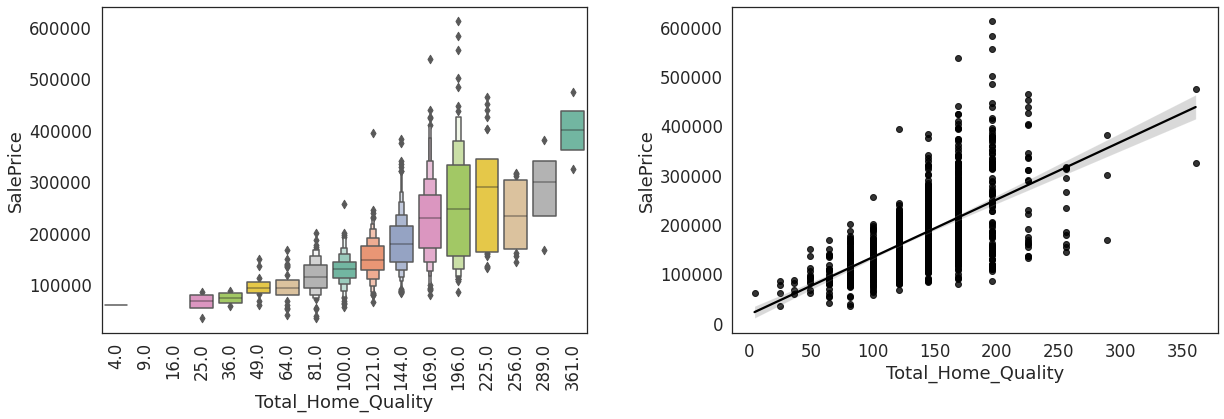

In [65]:
house_df['Total_Home_Quality'] = (house_df['OverallQual'] + house_df['OverallCond'])**2
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='Total_Home_Quality',y='SalePrice',palette='Set2')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='Total_Home_Quality',y='SalePrice',color='black')

<AxesSubplot:xlabel='Total_Bathrooms', ylabel='SalePrice'>

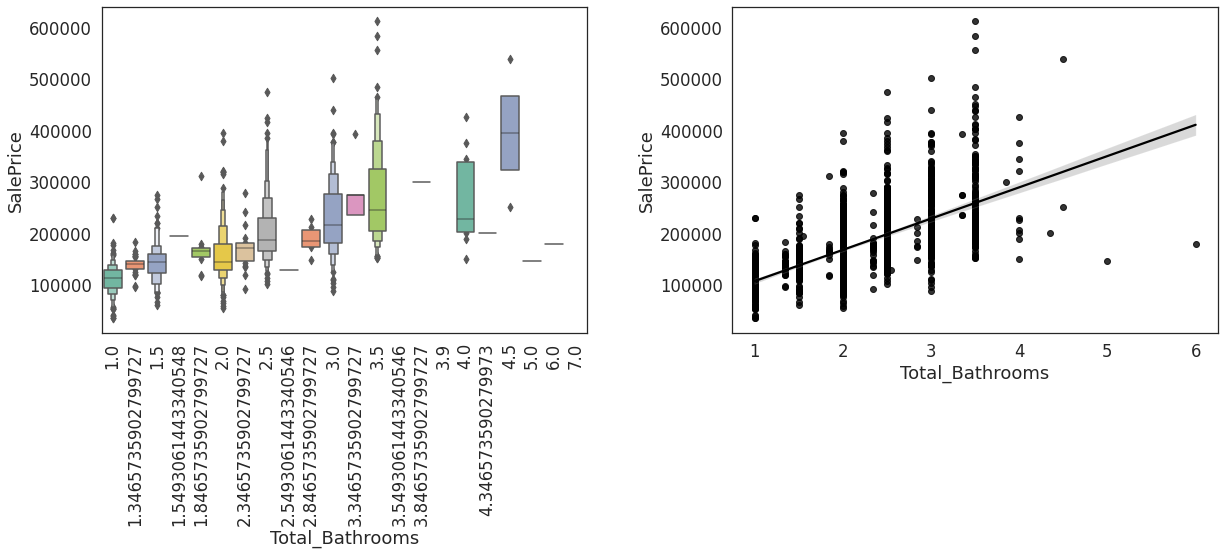

In [66]:
house_df['Total_Bathrooms'] = (house_df['FullBath'] + (0.5 * house_df['HalfBath']) + (house_df['BsmtFullBath'] + (0.5 * house_df['BsmtHalfBath'])))
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='Total_Bathrooms',y='SalePrice',palette='Set2')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='Total_Bathrooms',y='SalePrice',color='black')

<AxesSubplot:xlabel='total_condition', ylabel='SalePrice'>

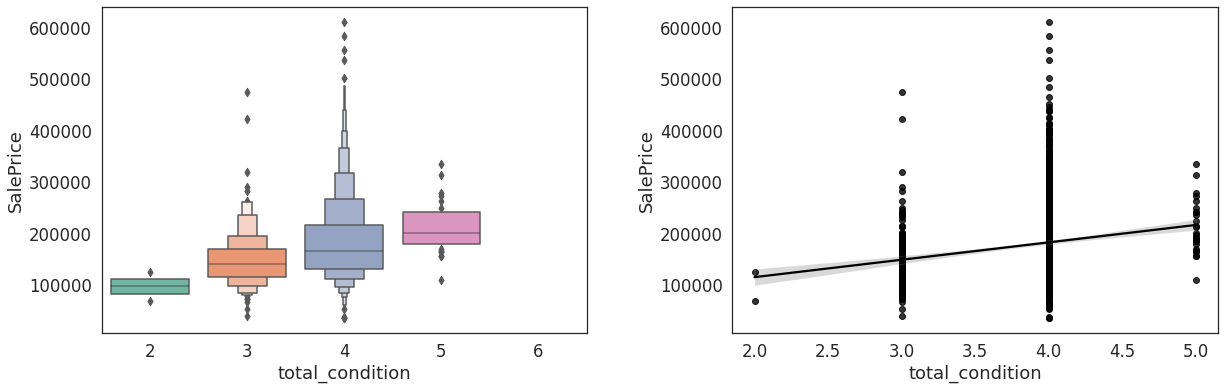

In [67]:
house_df['total_condition'] = house_df['Condition1'] + house_df['Condition2'] 
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='total_condition',y='SalePrice',palette='Set2')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='total_condition',y='SalePrice',color='black')

<AxesSubplot:xlabel='SqFtPerRoom', ylabel='SalePrice'>

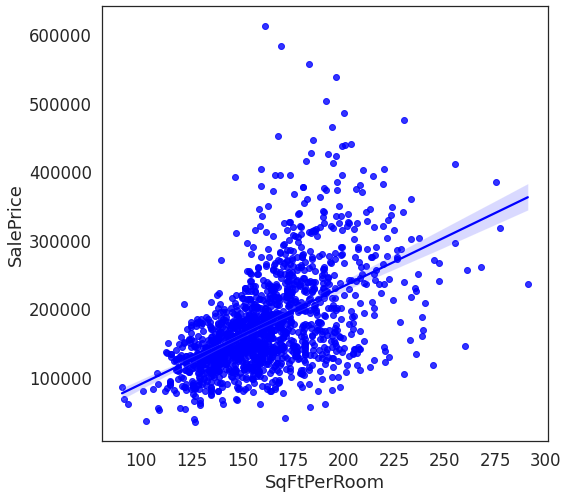

In [68]:
house_df["SqFtPerRoom"] = house_df["GrLivArea"] / (house_df["TotRmsAbvGrd"] +
                                                       house_df["FullBath"] +
                                                       house_df["HalfBath"] +
                                                       house_df["KitchenAbvGr"])
plt.figure(figsize=(8,8))
sns.regplot(data=house_df, x='SqFtPerRoom',y='SalePrice',color='blue')

<AxesSubplot:>

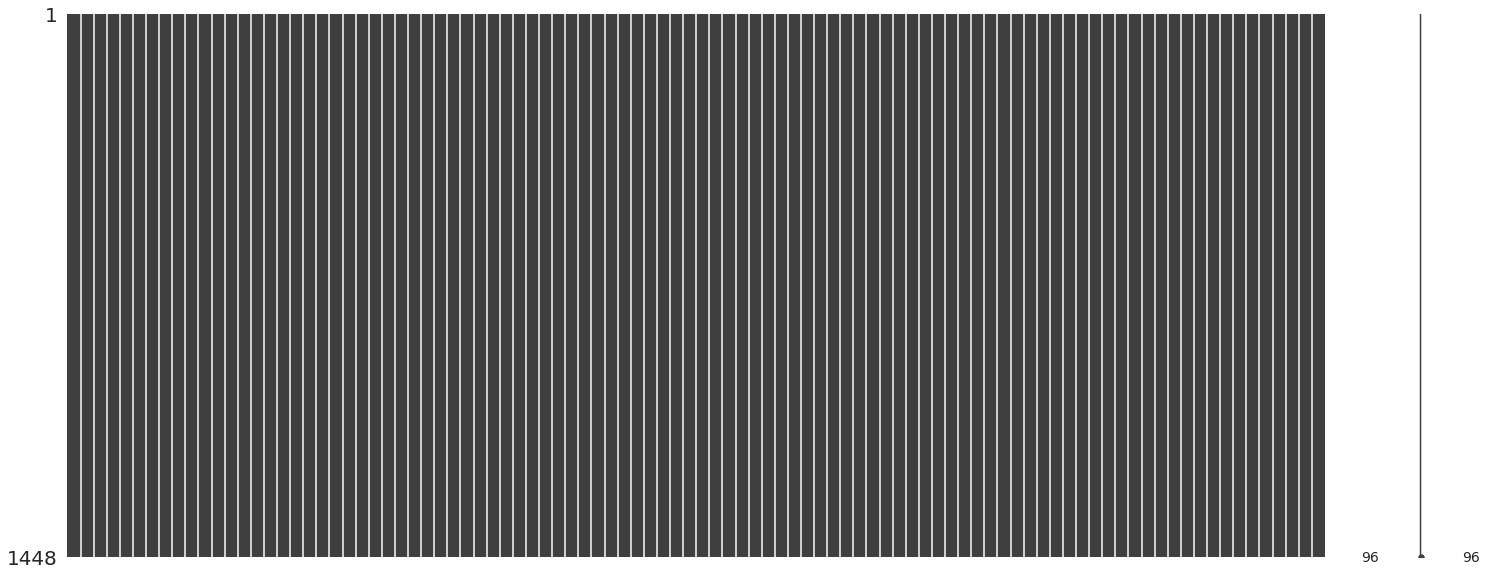

In [69]:
import missingno as msno
msno.matrix(house_df[tr_idx])

Text(0.5, 1.0, 'Correlation with SalePrice')

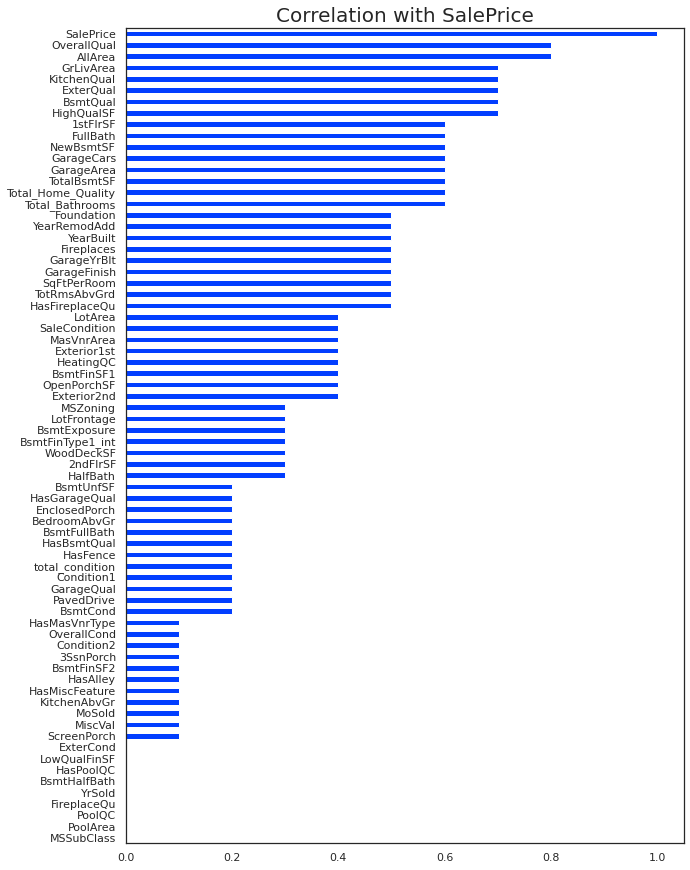

In [70]:
corr=house_df.corr().round(1)
sns.set(font_scale=1)
plt.figure(figsize=(10, 15))
sns.set_style("white")
sns.set_palette("bright")
abs(corr['SalePrice']).sort_values()[:-1].plot.barh()
plt.gca().set_facecolor('#FFFFFF')
plt.title('Correlation with SalePrice',fontsize=20)

In [71]:
abs_corr = abs(corr['SalePrice']).sort_values()[:-1]
low_corr_list = abs_corr[abs_corr.values == 0].index
house_df.drop(low_corr_list, axis=1,inplace=True)

In [72]:
house_df = pd.get_dummies(house_df, drop_first=True)

In [73]:
house_df['SalePriceCpy'] = np.log1p(house_df['SalePrice'])
house_df.drop('SalePrice',axis=1,inplace=True)
house_df['SalePrice'] = house_df['SalePriceCpy'].copy()
house_df.drop('SalePriceCpy',axis=1,inplace=True)

In [74]:
house_train_x = house_df.drop('SalePrice',axis=1)
all_cols = [cname for cname in house_train_x.columns]
house_train_y = house_df['SalePrice']

<AxesSubplot:>

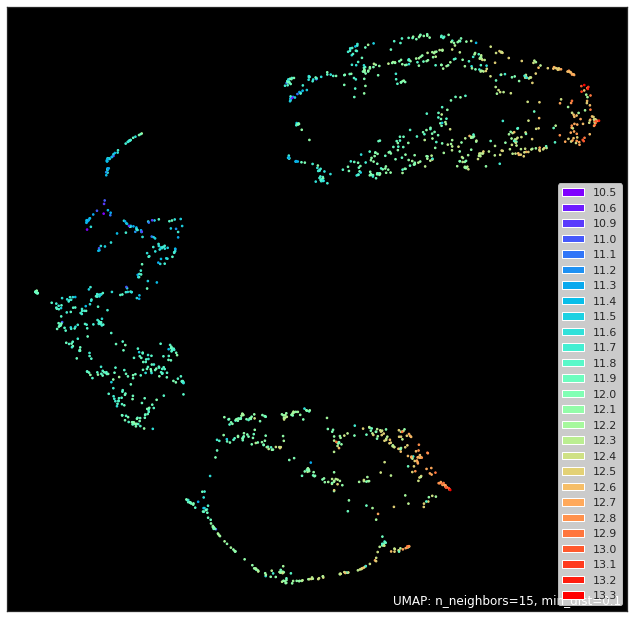

In [75]:
import umap
import umap.plot
mapper = umap.UMAP().fit(house_train_x[tr_idx])
umap.plot.points(mapper, labels=house_train_y[tr_idx].round(1), theme='fire')

In [76]:
import plotly
import plotly.express as px
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(house_train_x[tr_idx])
umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(house_train_y[tr_idx],name='price')
print(type(x_umap))
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='price', labels={'color': 'number'}
)
fig.update_traces(marker_size=1.5)
fig.show()

<class 'numpy.ndarray'>
